### This notebook looks at the impact of systematically deleting SC ... to the OUTER networks i.e., from ntwx A to ntwx B, C, etc

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
from collections import Counter

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
import pickle

In [5]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [6]:
import re

In [7]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [8]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [9]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [10]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 59.3 s, sys: 668 ms, total: 1min
Wall time: 1min 9s


In [11]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.51 s, sys: 130 ms, total: 1.64 s
Wall time: 1.64 s


In [12]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [13]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [14]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
    ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
    all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
    ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
    all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
    all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
    all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
    ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
    all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
    all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
    all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 2min 33s, sys: 3.89 s, total: 2min 37s
Wall time: 6min 37s


In [15]:
all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
                        all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
                        all_subs_limbic_lesion,all_subs_fpn_lesion,
                        all_subs_dmn_lesion]

In [16]:
# for now deal with avg fc of DMN lesion only (across all ntwx) ...
# This is OUTER connectivity ... i.e., the average ntwx conn to other ntwx (so Vis to SomMot, DorsAttn, ..., DMN etc)

# all_subs_og_whobpyt
# all_subs_dmn_lesion

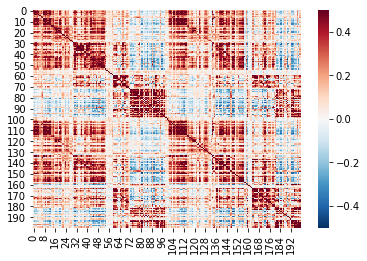

In [17]:
sns.heatmap(all_subs_emp_fc_mat[99], cmap='RdBu_r',center=0,vmax=0.5)

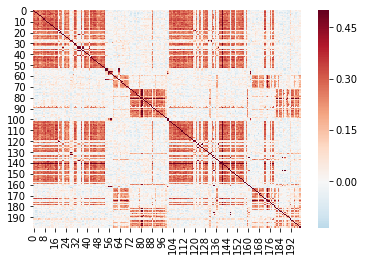

In [18]:
sns.heatmap(all_subs_og_whobpyt[99], cmap='RdBu_r',center=0,vmax=0.5)

In [19]:
i = 99

print(np.corrcoef(all_subs_og_whobpyt[i][mask], all_subs_emp_fc_mat[i][mask])[0][1])

0.6288580771510476


In [20]:
from numpy.polynomial.polynomial import polyfit

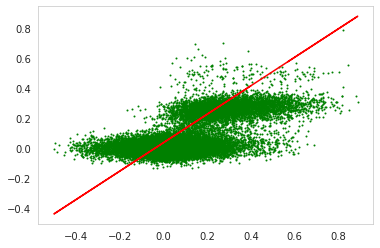

In [21]:
rww_test = all_subs_og_whobpyt[99][mask].flatten()

rww_test2 = all_subs_emp_fc_mat[99][mask].flatten()

m, b = np.polyfit(rww_test, rww_test2, 1)

sns.set_style('whitegrid')
fig,ax = plt.subplots()
plt.scatter(rww_test2, rww_test, color='green',s=1)
plt.plot(rww_test2, m*rww_test2 + b, color='red')
plt.grid(visible=False)

plt.show()

In [22]:
# for i in range(10):
#     print(np.corrcoef(all_subs_og_whobpyt[i][mask], all_subs_emp_fc_mat[i][mask])[0][1])

In [23]:
# for i in range(10):
#     rww_test = all_subs_og_whobpyt[i][mask].flatten()

#     rww_test2 = all_subs_emp_fc_mat[i][mask].flatten()

#     m, b = np.polyfit(rww_test, rww_test2, 1)

#     sns.set_style('whitegrid')
#     fig,ax = plt.subplots()
#     plt.scatter(rww_test2, rww_test, color='green',s=1)
#     plt.plot(rww_test2, m*rww_test2 + b, color='red')
#     plt.grid(visible=False)

#     plt.show()

In [24]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [25]:
# corrs_list

In [26]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [27]:
# vis --> (0,14,100,115)
# sommot --> (14,30,115,134)
# dorsattn --> (30,43,134,147)
# ventattn --> (43,54,147,158)
# limbic --> (54,60,158,164)
# fpn --> (60,73,164,181)
# dmn --> (73,100,181,200)

In [29]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

In [30]:
def outer_ntwx_only_fc(fc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_fc = (np.mean(lh_ntwx_to_lh_vis) + np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/4
    mean_ntwx_to_sommot_fc = (np.mean(lh_ntwx_to_lh_sommot) + np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))/4
    mean_ntwx_to_dorsattn_fc = (np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))/4
    mean_ntwx_to_ventattn_fc = (np.mean(lh_ntwx_to_lh_ventattn) + np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))/4
    mean_ntwx_to_limbic_fc = (np.mean(lh_ntwx_to_lh_limbic) + np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))/4
    mean_ntwx_to_fpn_fc = (np.mean(lh_ntwx_to_lh_fpn) + np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/4
    mean_ntwx_to_dmn_fc = (np.mean(lh_ntwx_to_lh_dmn) + np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/4
    
    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
    
#     if num == 0:
#         return mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 1:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 2:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 3:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 4:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
#     elif num == 5:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_dmn_fc
#     elif num == 6:
#         return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc

### original WhoBPyT

In [31]:
%%time

all_subs_vis_to_other_ntwx = []
all_subs_sommot_to_other_ntwx = []
all_subs_dorsattn_to_other_ntwx = []
all_subs_ventattn_to_other_ntwx = []
all_subs_limbic_to_other_ntwx = []
all_subs_fpn_to_other_ntwx = []
all_subs_dmn_to_other_ntwx = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,0)
    all_subs_vis_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,1)
    all_subs_sommot_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,2)
    all_subs_dorsattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,3)
    all_subs_ventattn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,4)
    all_subs_limbic_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,5)
    all_subs_fpn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(all_subs_og_whobpyt,i,6)
    all_subs_dmn_to_other_ntwx.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

CPU times: user 795 ms, sys: 7.17 ms, total: 803 ms
Wall time: 898 ms


In [32]:
og_whobpyt_vis_to_other_ntwx = np.mean(all_subs_vis_to_other_ntwx,axis=0)
og_whobpyt_sommot_to_other_ntwx = np.mean(all_subs_sommot_to_other_ntwx,axis=0)
og_whobpyt_dorsattn_to_other_ntwx = np.mean(all_subs_dorsattn_to_other_ntwx,axis=0)
og_whobpyt_ventattn_to_other_ntwx = np.mean(all_subs_ventattn_to_other_ntwx,axis=0)
og_whobpyt_limbic_to_other_ntwx = np.mean(all_subs_limbic_to_other_ntwx,axis=0)
og_whobpyt_fpn_to_other_ntwx = np.mean(all_subs_fpn_to_other_ntwx,axis=0)
og_whobpyt_dmn_to_other_ntwx = np.mean(all_subs_dmn_to_other_ntwx,axis=0)

In [33]:
# Across all 200 subs
og_whobpyt_outer_to_other_ntwx  = [og_whobpyt_vis_to_other_ntwx,og_whobpyt_sommot_to_other_ntwx,
                                   og_whobpyt_dorsattn_to_other_ntwx,og_whobpyt_ventattn_to_other_ntwx,
                                   og_whobpyt_limbic_to_other_ntwx,og_whobpyt_fpn_to_other_ntwx,
                                   og_whobpyt_dmn_to_other_ntwx]

### Lesion WhoBPyT

In [34]:
def get_outer_ntwx_fc(fc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_sommot_to_other_ntwx_lesions = []
    all_subs_dorsattn_to_other_ntwx_lesions = []
    all_subs_ventattn_to_other_ntwx_lesions = []
    all_subs_limbic_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_sommot_to_other_ntwx_lesions = np.mean(all_subs_sommot_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dorsattn_to_other_ntwx_lesions = np.mean(all_subs_dorsattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_ventattn_to_other_ntwx_lesions = np.mean(all_subs_ventattn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_limbic_to_other_ntwx_lesions = np.mean(all_subs_limbic_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_sommot_to_other_ntwx_lesions,mean_all_subs_dorsattn_to_other_ntwx_lesions,mean_all_subs_ventattn_to_other_ntwx_lesions,mean_all_subs_limbic_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [35]:
# all_subs_lesion_ntwx = [all_subs_vis_lesion,all_subs_sommot_lesion,
#                         all_subs_dorsattn_lesion,all_subs_ventattn_lesion,
#                         all_subs_limbic_lesion,all_subs_fpn_lesion,
#                         all_subs_dmn_lesion]

In [36]:
len(all_subs_vis_lesion)

200

In [37]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_vis_lesion)

sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_sommot_lesion)

dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dorsattn_lesion)

ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_ventattn_lesion)

limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_limbic_lesion)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_fpn_lesion)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_outer_ntwx_fc(all_subs_dmn_lesion)


CPU times: user 5.41 s, sys: 249 ms, total: 5.66 s
Wall time: 5.62 s


In [38]:
vis_lesion_outer_to_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_sommot_to_other_ntwx, vis_lesion_dorsattn_to_other_ntwx, vis_lesion_ventattn_to_other_ntwx, vis_lesion_limbic_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [sommot_lesion_vis_to_other_ntwx, sommot_lesion_sommot_to_other_ntwx, sommot_lesion_dorsattn_to_other_ntwx, sommot_lesion_ventattn_to_other_ntwx, sommot_lesion_limbic_to_other_ntwx, sommot_lesion_fpn_to_other_ntwx, sommot_lesion_dmn_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [dorsattn_lesion_vis_to_other_ntwx, dorsattn_lesion_sommot_to_other_ntwx, dorsattn_lesion_dorsattn_to_other_ntwx, dorsattn_lesion_ventattn_to_other_ntwx, dorsattn_lesion_limbic_to_other_ntwx, dorsattn_lesion_fpn_to_other_ntwx, dorsattn_lesion_dmn_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [ventattn_lesion_vis_to_other_ntwx, ventattn_lesion_sommot_to_other_ntwx, ventattn_lesion_dorsattn_to_other_ntwx, ventattn_lesion_ventattn_to_other_ntwx, ventattn_lesion_limbic_to_other_ntwx, ventattn_lesion_fpn_to_other_ntwx, ventattn_lesion_dmn_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [limbic_lesion_vis_to_other_ntwx, limbic_lesion_sommot_to_other_ntwx, limbic_lesion_dorsattn_to_other_ntwx, limbic_lesion_ventattn_to_other_ntwx, limbic_lesion_limbic_to_other_ntwx, limbic_lesion_fpn_to_other_ntwx, limbic_lesion_dmn_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_sommot_to_other_ntwx, fpn_lesion_dorsattn_to_other_ntwx, fpn_lesion_ventattn_to_other_ntwx, fpn_lesion_limbic_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_sommot_to_other_ntwx, dmn_lesion_dorsattn_to_other_ntwx, dmn_lesion_ventattn_to_other_ntwx, dmn_lesion_limbic_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [39]:
og_whobpyt_outer_to_other_ntwx

[array([0.23810393, 0.11751197, 0.15970269, 0.1320959 , 0.01075976,
        0.046246  , 0.03316372]),
 array([0.11751197, 0.18159083, 0.13324247, 0.12123741, 0.00758863,
        0.03571476, 0.02804925]),
 array([0.15970269, 0.13324247, 0.21459718, 0.15444755, 0.00950485,
        0.06107632, 0.03384539]),
 array([0.1320959 , 0.12123741, 0.15444755, 0.19481845, 0.01046675,
        0.05758871, 0.03098714]),
 array([0.01075976, 0.00758863, 0.00950485, 0.01046675, 0.11863332,
        0.02487002, 0.03669535]),
 array([0.046246  , 0.03571476, 0.06107632, 0.05758871, 0.02487002,
        0.1287454 , 0.07125633]),
 array([0.03316372, 0.02804925, 0.03384539, 0.03098714, 0.03669535,
        0.07125633, 0.13045475])]

In [40]:
for i in range(7):
    print(og_whobpyt_outer_to_other_ntwx[i][i])

0.2381039300052709
0.18159082694176332
0.21459717983754742
0.19481845006681608
0.11863332314529479
0.12874539763860973
0.13045474625933845


In [41]:
og_whobpyt_outer_to_other_ntwx = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx]


In [42]:
# og_whobpyt_outer_to_other_ntwx

In [43]:
vis_lesion_outer_to_other_ntwx = [arr.tolist() for arr in vis_lesion_outer_to_other_ntwx]
sommot_lesion_outer_to_other_ntwx = [arr.tolist() for arr in sommot_lesion_outer_to_other_ntwx]
dorsattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dorsattn_lesion_outer_to_other_ntwx]
ventattn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in ventattn_lesion_outer_to_other_ntwx]
limbic_lesion_outer_to_other_ntwx = [arr.tolist() for arr in limbic_lesion_outer_to_other_ntwx]
fpn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in fpn_lesion_outer_to_other_ntwx]
dmn_lesion_outer_to_other_ntwx = [arr.tolist() for arr in dmn_lesion_outer_to_other_ntwx]

In [44]:
# for i in range(7):
#     print(_var_temp[i][i][i])

In [45]:
_var = [og_whobpyt_outer_to_other_ntwx,
vis_lesion_outer_to_other_ntwx,
sommot_lesion_outer_to_other_ntwx,
dorsattn_lesion_outer_to_other_ntwx,
ventattn_lesion_outer_to_other_ntwx,
limbic_lesion_outer_to_other_ntwx,
fpn_lesion_outer_to_other_ntwx,
dmn_lesion_outer_to_other_ntwx]

In [46]:
data = _var.copy()

In [47]:
len(og_whobpyt_outer_to_other_ntwx)

7

In [48]:
og_whobpyt_outer_to_other_ntwx[0]

[0.2381039300052709,
 0.11751196796422667,
 0.15970269457199873,
 0.1320958999245613,
 0.010759757448348442,
 0.04624599713047237,
 0.033163721097579583]

In [49]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

#### Visual

In [50]:
og_whobpyt_outer_to_other_ntwx[2]

[0.15970269457199873,
 0.13324246969000894,
 0.21459717983754742,
 0.1544475532054185,
 0.00950484775299248,
 0.06107631573450146,
 0.03384538826718803]

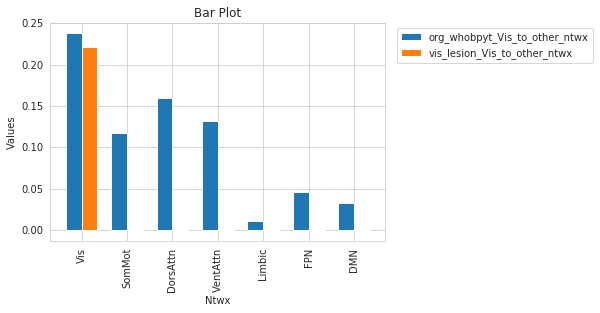

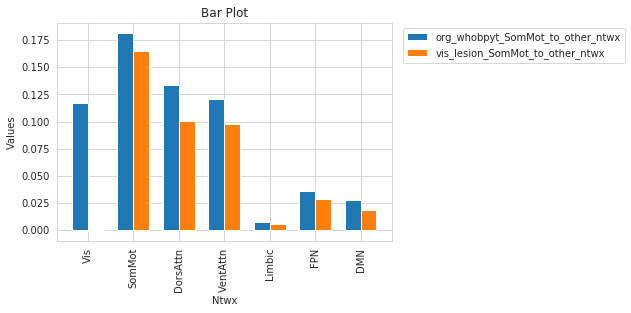

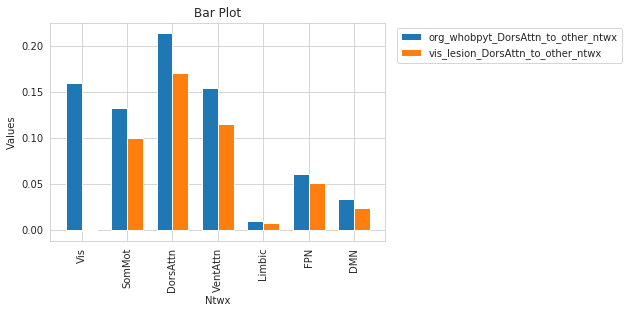

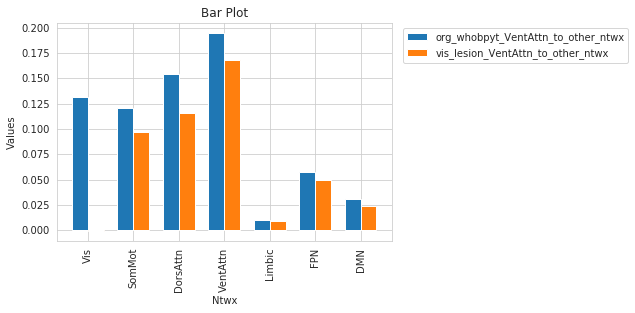

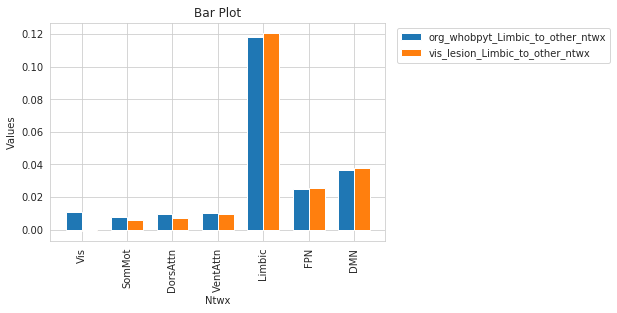

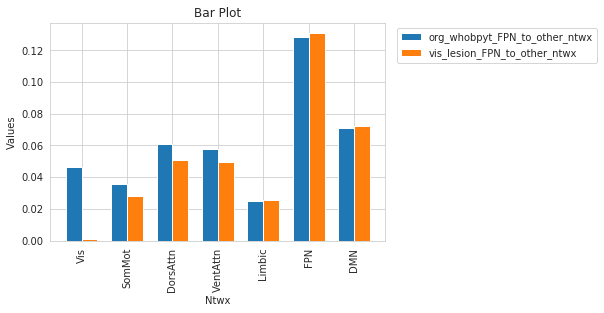

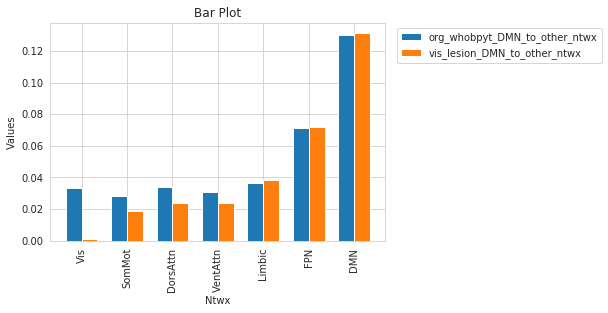

In [51]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], vis_lesion_outer_to_other_ntwx[j], width, label='vis_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

In [71]:
list1 = og_whobpyt_outer_to_other_ntwx[3] 

list2 = vis_lesion_outer_to_other_ntwx[3]

In [72]:
difference_list = [a - b for a, b in zip(list1, list2)]
difference_list

[0.1323854311978316,
 0.023659068252424753,
 0.038457920766706594,
 0.026280935055068594,
 0.0011415905172353098,
 0.008035782010156166,
 0.007156677375600631]

#### SomMot

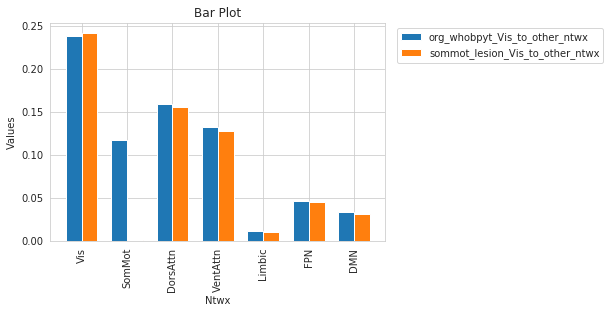

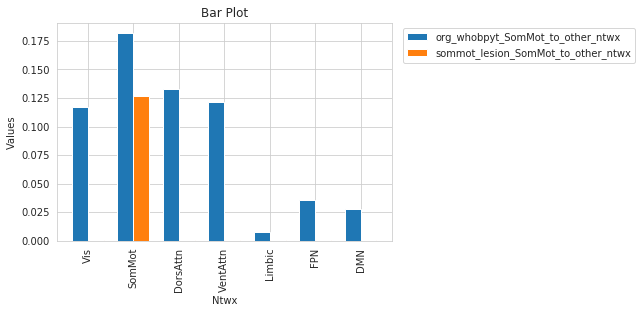

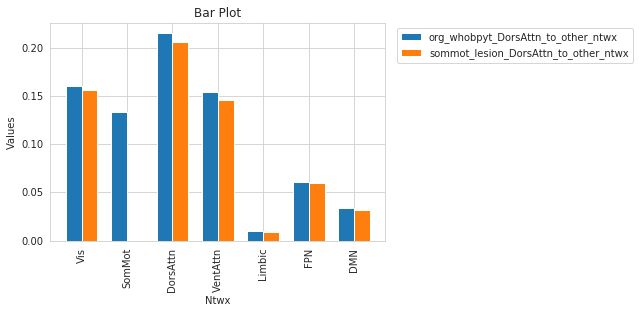

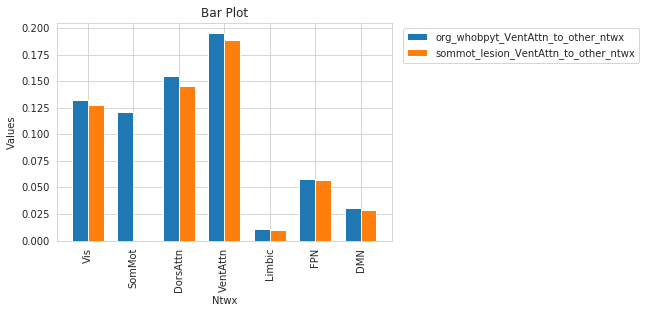

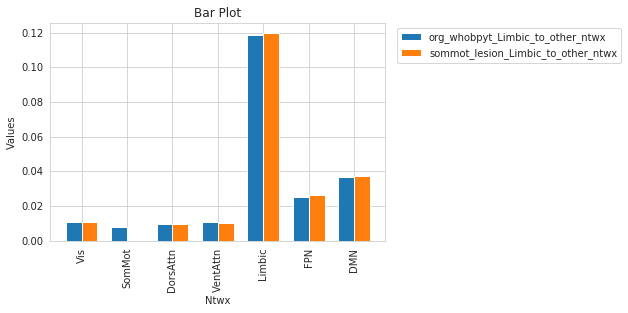

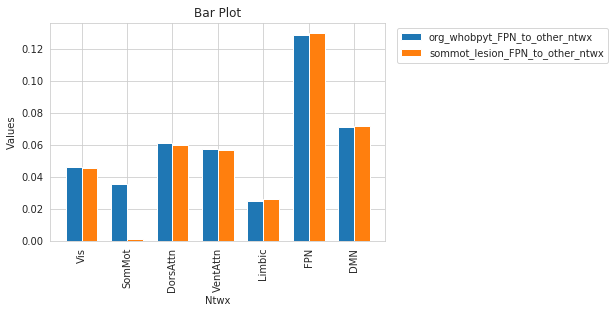

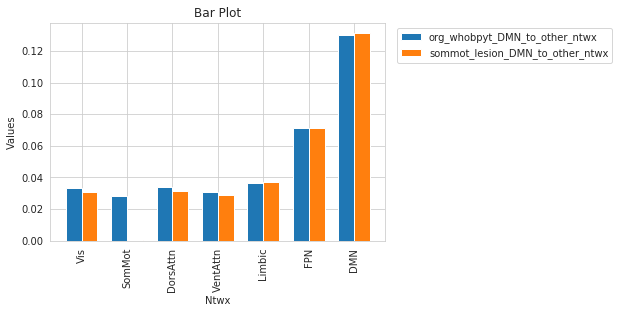

In [52]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], sommot_lesion_outer_to_other_ntwx[j], width, label='sommot_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DorsAttn

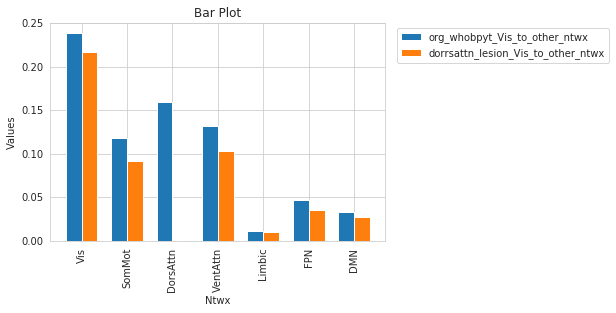

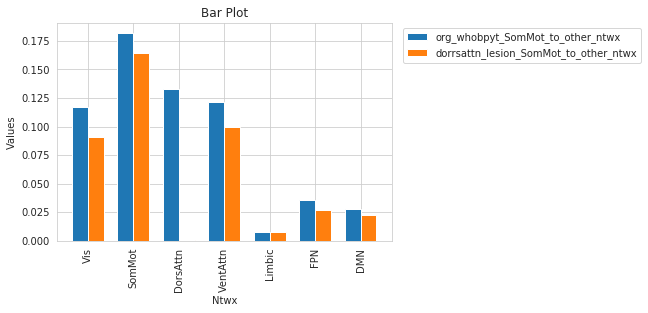

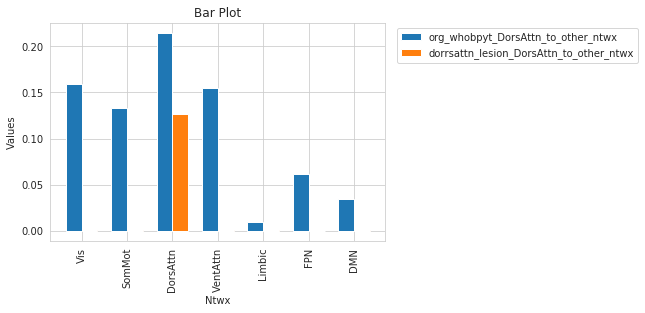

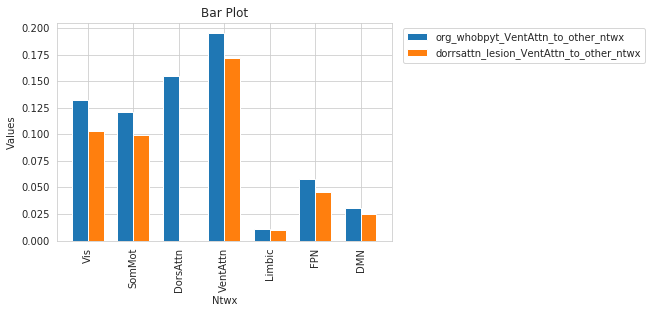

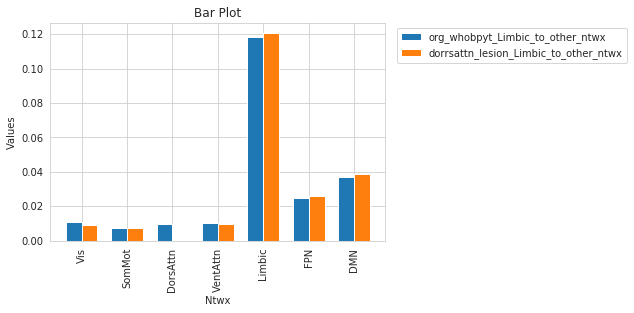

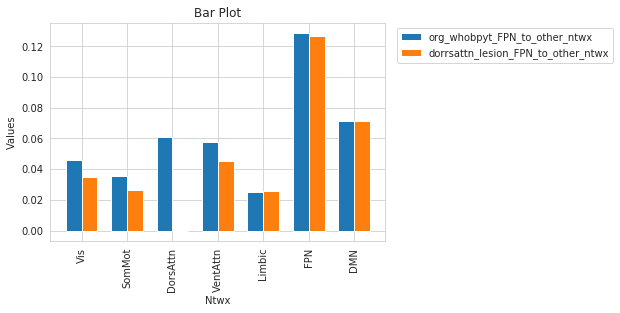

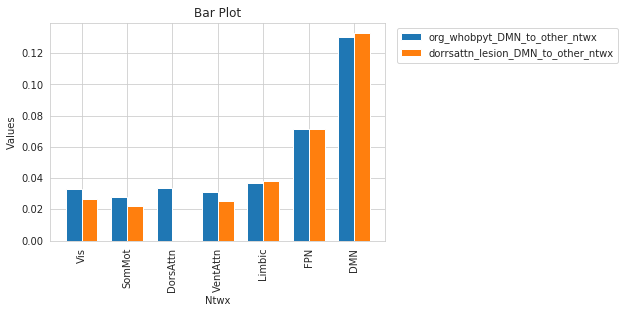

In [53]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dorsattn_lesion_outer_to_other_ntwx[j], width, label='dorrsattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### VentAttn

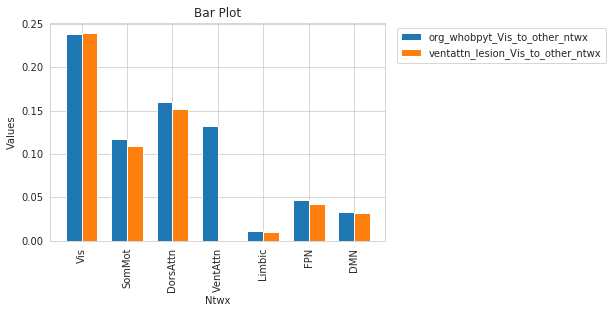

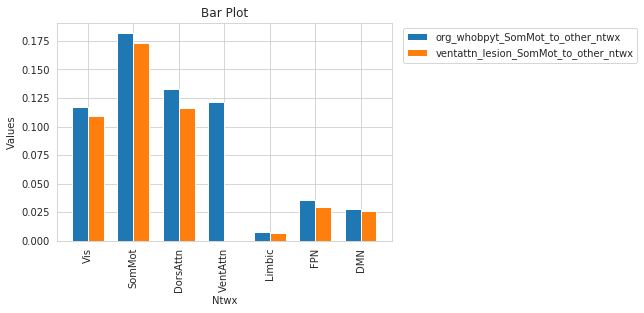

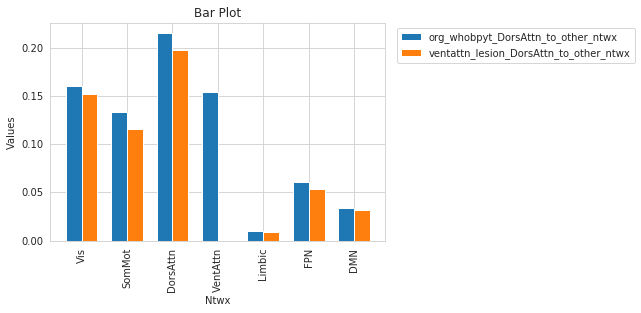

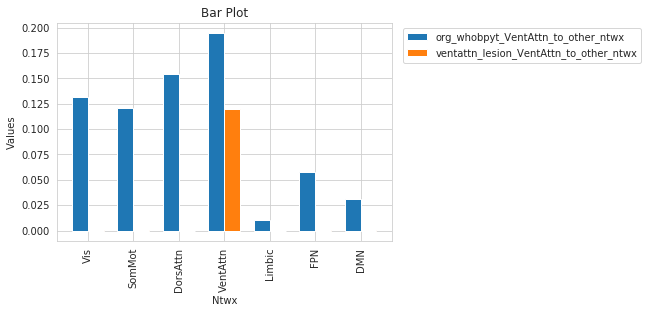

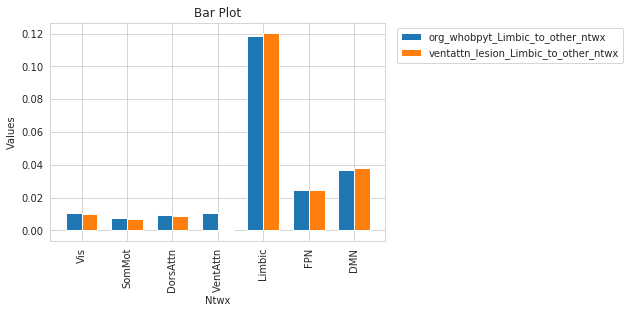

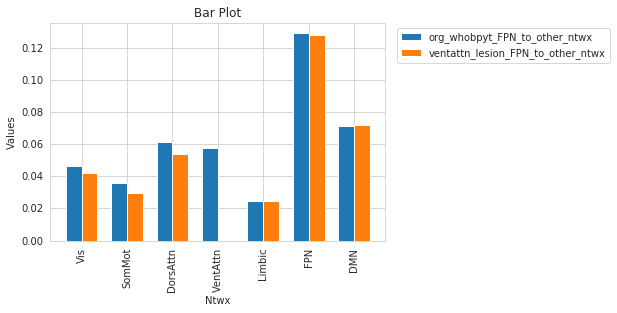

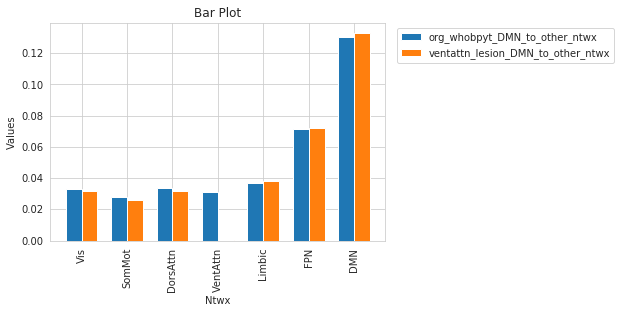

In [54]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], ventattn_lesion_outer_to_other_ntwx[j], width, label='ventattn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### Limbic

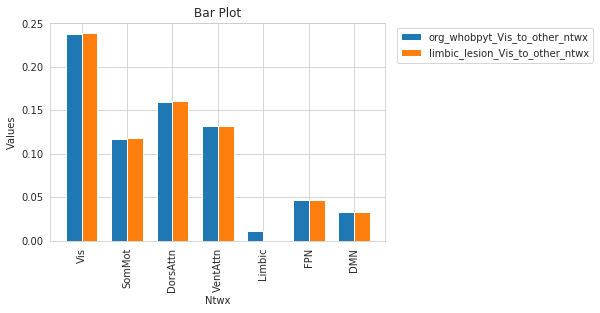

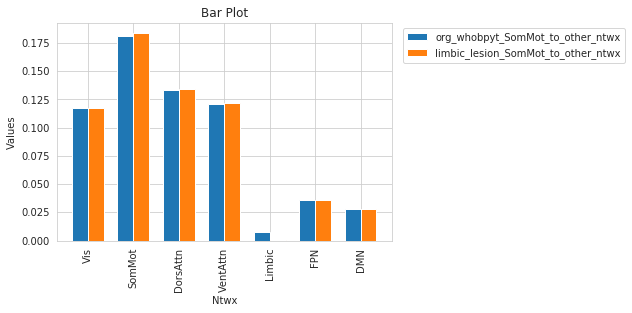

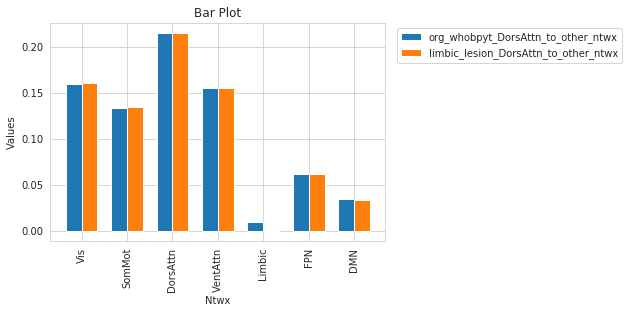

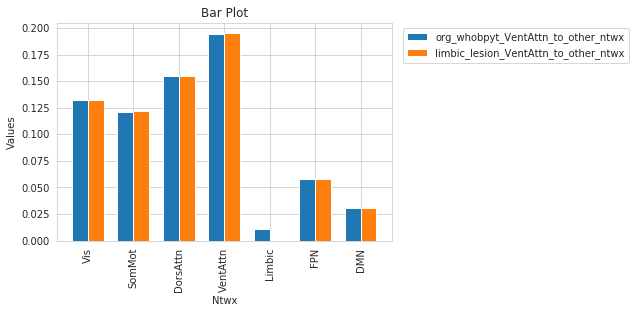

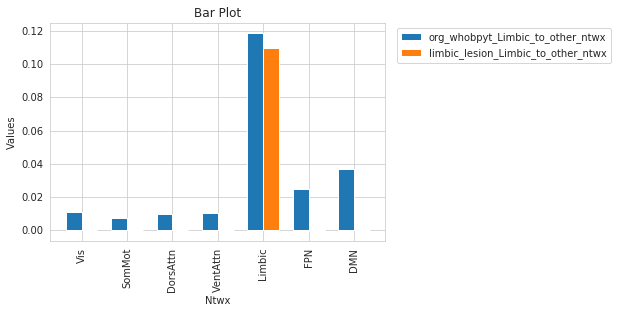

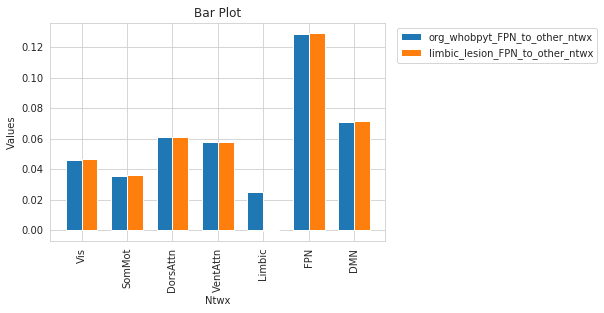

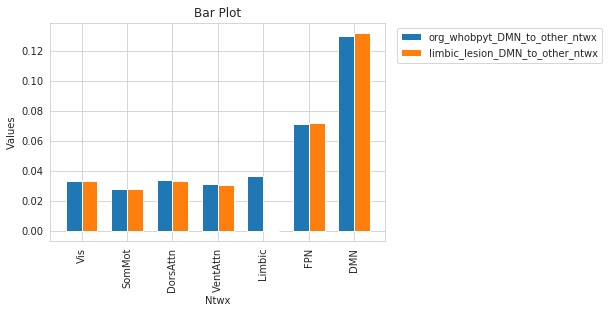

In [55]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], limbic_lesion_outer_to_other_ntwx[j], width, label='limbic_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

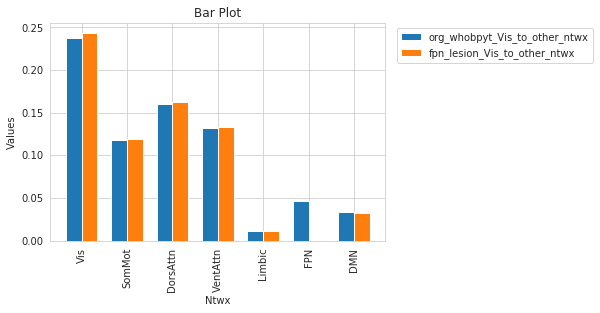

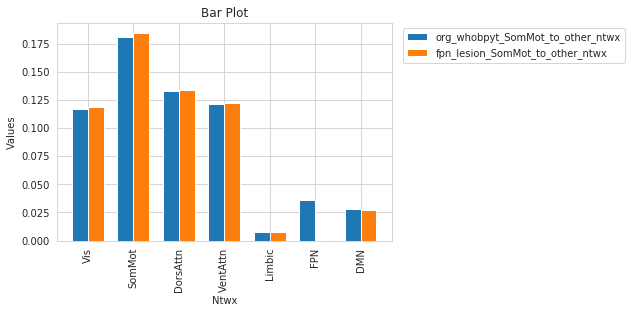

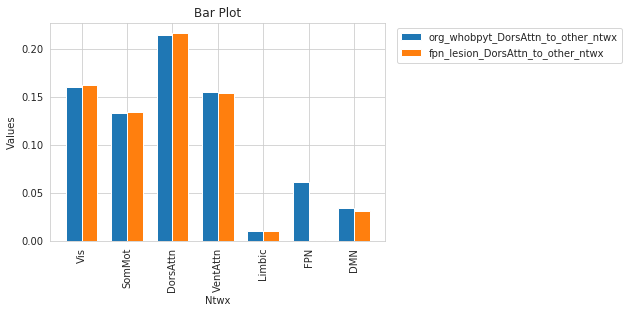

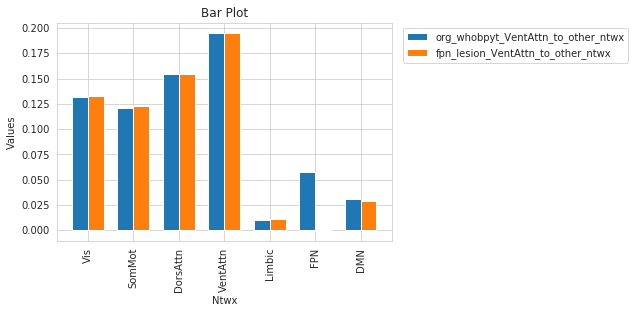

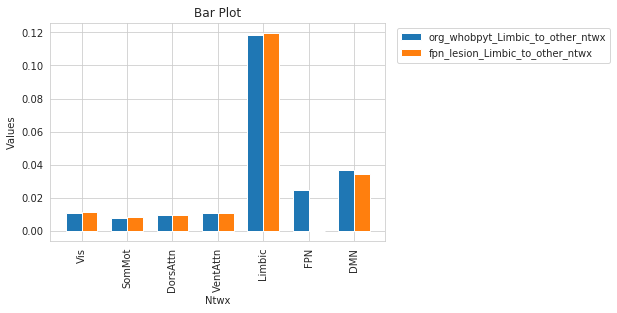

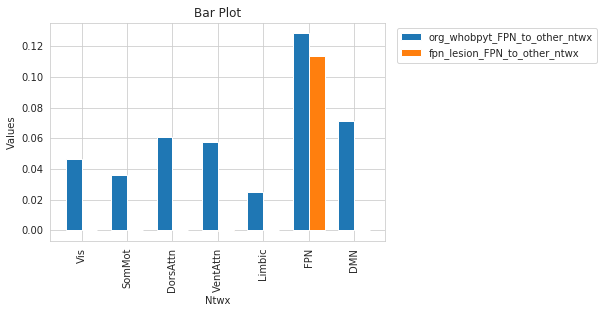

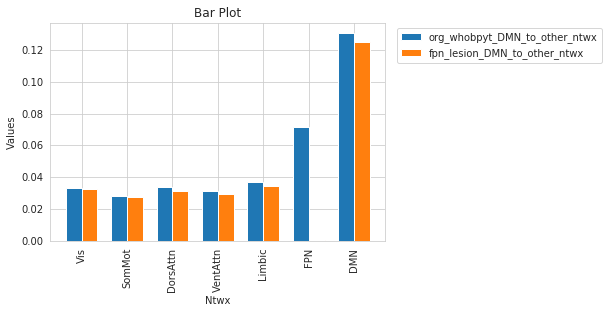

In [56]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], fpn_lesion_outer_to_other_ntwx[j], width, label='fpn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DMN

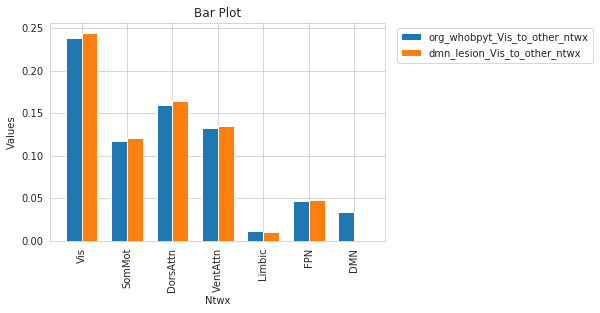

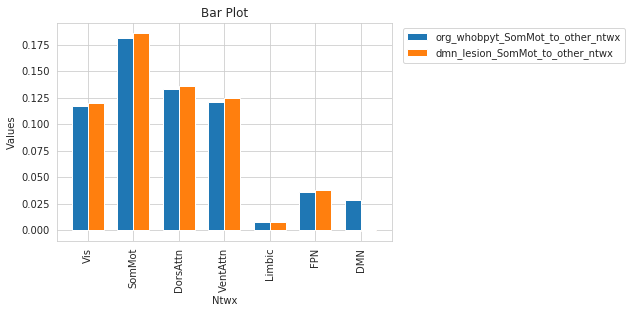

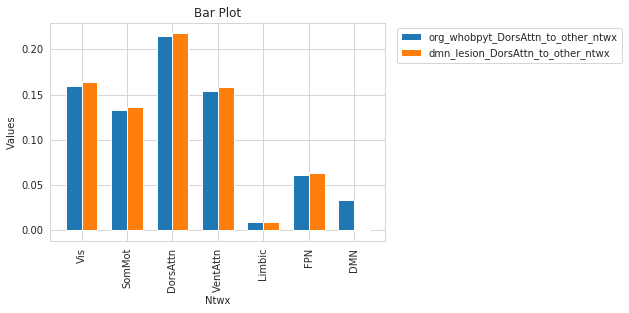

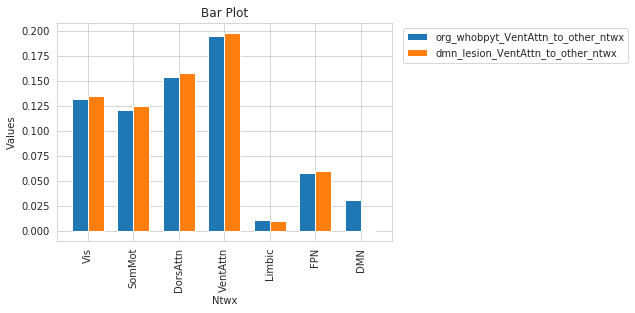

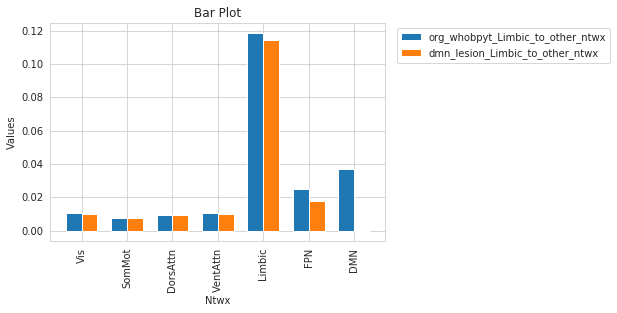

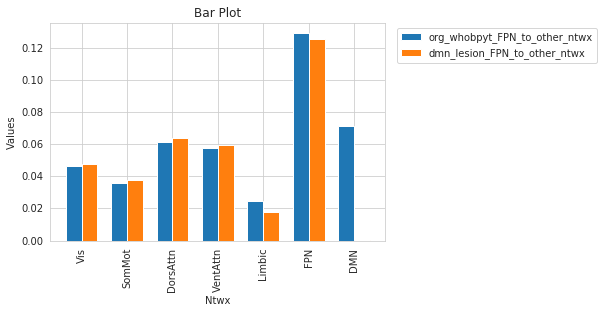

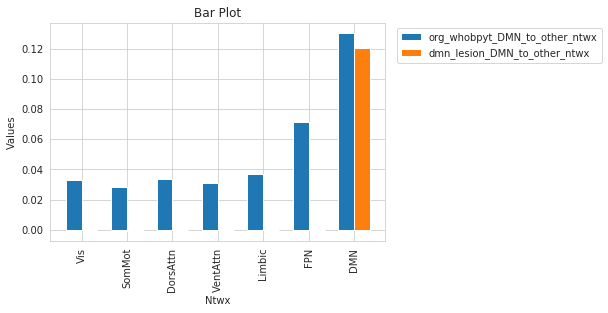

In [57]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx[j], width, label='org_whobpyt_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dmn_lesion_outer_to_other_ntwx[j], width, label='dmn_lesion_{0}_to_other_ntwx'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

## with thresholds

In [ ]:
def outer_ntwx_only_fc_with_thresh(fc, sub, num):
    
    thresh = 0.2
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    
    lh_ntwx_to_lh_vis = lh_ntwx_to_lh_vis[(lh_ntwx_to_lh_vis>0.1)]
    lh_ntwx_to_rh_vis = lh_ntwx_to_rh_vis[(lh_ntwx_to_rh_vis>0.1)]
    lh_ntwx_to_lh_sommot = lh_ntwx_to_lh_sommot[(lh_ntwx_to_lh_sommot>0.1)]
    lh_ntwx_to_rh_sommot = lh_ntwx_to_rh_sommot[(lh_ntwx_to_rh_sommot>0.1)]
    lh_ntwx_to_lh_dorsattn = lh_ntwx_to_lh_dorsattn[(lh_ntwx_to_lh_dorsattn>0.1)]
    lh_ntwx_to_rh_dorsattn = lh_ntwx_to_rh_dorsattn[(lh_ntwx_to_rh_dorsattn>0.1)]
    lh_ntwx_to_lh_ventattn = lh_ntwx_to_lh_ventattn[(lh_ntwx_to_lh_ventattn>0.1)]
    lh_ntwx_to_rh_ventattn = lh_ntwx_to_rh_ventattn[(lh_ntwx_to_rh_ventattn>0.1)]
    lh_ntwx_to_lh_limbic = lh_ntwx_to_lh_limbic[(lh_ntwx_to_lh_limbic>0.1)]
    lh_ntwx_to_rh_limbic = lh_ntwx_to_rh_limbic[(lh_ntwx_to_rh_limbic>0.1)]
    lh_ntwx_to_lh_fpn = lh_ntwx_to_lh_fpn[(lh_ntwx_to_lh_fpn>0.1)]
    lh_ntwx_to_rh_fpn = lh_ntwx_to_rh_fpn[(lh_ntwx_to_rh_fpn>0.1)]
    lh_ntwx_to_lh_dmn = lh_ntwx_to_lh_dmn[(lh_ntwx_to_lh_dmn>0.1)]
    lh_ntwx_to_rh_dmn = lh_ntwx_to_rh_dmn[(lh_ntwx_to_rh_dmn>0.1)]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
    
    rh_ntwx_to_lh_vis = rh_ntwx_to_lh_vis[(rh_ntwx_to_lh_vis>0.1)]
    rh_ntwx_to_rh_vis = rh_ntwx_to_rh_vis[(rh_ntwx_to_rh_vis>0.1)]
    rh_ntwx_to_lh_sommot = rh_ntwx_to_lh_sommot[(rh_ntwx_to_lh_sommot>0.1)]
    rh_ntwx_to_rh_sommot = rh_ntwx_to_rh_sommot[(rh_ntwx_to_rh_sommot>0.1)]
    rh_ntwx_to_lh_dorsattn = rh_ntwx_to_lh_dorsattn[(rh_ntwx_to_lh_dorsattn>0.1)]
    rh_ntwx_to_rh_dorsattn = rh_ntwx_to_rh_dorsattn[(rh_ntwx_to_rh_dorsattn>0.1)]
    rh_ntwx_to_lh_ventattn = rh_ntwx_to_lh_ventattn[(rh_ntwx_to_lh_ventattn>0.1)]
    rh_ntwx_to_rh_ventattn = rh_ntwx_to_rh_ventattn[(rh_ntwx_to_rh_ventattn>0.1)]
    rh_ntwx_to_lh_limbic = rh_ntwx_to_lh_limbic[(rh_ntwx_to_lh_limbic>0.1)]
    rh_ntwx_to_rh_limbic = rh_ntwx_to_rh_limbic[(rh_ntwx_to_rh_limbic>0.1)]
    rh_ntwx_to_lh_fpn = rh_ntwx_to_lh_fpn[(rh_ntwx_to_lh_fpn>0.1)]
    rh_ntwx_to_rh_fpn = rh_ntwx_to_rh_fpn[(rh_ntwx_to_rh_fpn>0.1)]
    rh_ntwx_to_lh_dmn = rh_ntwx_to_lh_dmn[(rh_ntwx_to_lh_dmn>0.1)]
    rh_ntwx_to_rh_dmn = rh_ntwx_to_rh_dmn[(rh_ntwx_to_rh_dmn>0.1)]
        
    mean_ntwx_to_vis_fc = (np.mean(lh_ntwx_to_lh_vis) + np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/4
    mean_ntwx_to_sommot_fc = (np.mean(lh_ntwx_to_lh_sommot) + np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))/4
    mean_ntwx_to_dorsattn_fc = (np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))/4
    mean_ntwx_to_ventattn_fc = (np.mean(lh_ntwx_to_lh_ventattn) + np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))/4
    mean_ntwx_to_limbic_fc = (np.mean(lh_ntwx_to_lh_limbic) + np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))/4
    mean_ntwx_to_fpn_fc = (np.mean(lh_ntwx_to_lh_fpn) + np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/4
    mean_ntwx_to_dmn_fc = (np.mean(lh_ntwx_to_lh_dmn) + np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/4
    
    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
    


### Threshold (but for negative correlations)

In [ ]:
def outer_ntwx_only_fc_with_thresh_negative(fc, sub, num):
    
    thresh = 0
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = fc[sub][a:b, 0:14]
    lh_ntwx_to_lh_vis = lh_ntwx_to_lh_vis[(lh_ntwx_to_lh_vis<thresh)]
    lh_ntwx_to_rh_vis = fc[sub][a:b, 100:115]
    lh_ntwx_to_rh_vis = lh_ntwx_to_rh_vis[(lh_ntwx_to_rh_vis<thresh)]
    
    lh_ntwx_to_lh_sommot = fc[sub][a:b, 14:30]
    lh_ntwx_to_lh_sommot = lh_ntwx_to_lh_sommot[(lh_ntwx_to_lh_sommot<thresh)]
    lh_ntwx_to_rh_sommot = fc[sub][a:b, 115:134]
    lh_ntwx_to_rh_sommot = lh_ntwx_to_rh_sommot[(lh_ntwx_to_rh_sommot<thresh)]
    
    lh_ntwx_to_lh_dorsattn = fc[sub][a:b, 30:43]
    lh_ntwx_to_lh_dorsattn = lh_ntwx_to_lh_dorsattn[(lh_ntwx_to_lh_dorsattn<thresh)]
    lh_ntwx_to_rh_dorsattn = fc[sub][a:b, 134:147]
    lh_ntwx_to_rh_dorsattn = lh_ntwx_to_rh_dorsattn[(lh_ntwx_to_rh_dorsattn<thresh)]
    
    lh_ntwx_to_lh_ventattn = fc[sub][a:b, 43:54]
    lh_ntwx_to_lh_ventattn = lh_ntwx_to_lh_ventattn[(lh_ntwx_to_lh_ventattn<thresh)]
    lh_ntwx_to_rh_ventattn = fc[sub][a:b, 147:158]
    lh_ntwx_to_rh_ventattn = lh_ntwx_to_rh_ventattn[(lh_ntwx_to_rh_ventattn<thresh)]
    
    lh_ntwx_to_lh_limbic = fc[sub][a:b, 54:60]
    lh_ntwx_to_lh_limbic = lh_ntwx_to_lh_limbic[(lh_ntwx_to_lh_limbic<thresh)]
    lh_ntwx_to_rh_limbic = fc[sub][a:b, 158:164]
    lh_ntwx_to_rh_limbic = lh_ntwx_to_rh_limbic[(lh_ntwx_to_rh_limbic<thresh)]
    
    lh_ntwx_to_lh_fpn = fc[sub][a:b, 60:73]
    lh_ntwx_to_lh_fpn = lh_ntwx_to_lh_fpn[(lh_ntwx_to_lh_fpn<thresh)]
    lh_ntwx_to_rh_fpn = fc[sub][a:b, 164:181]
    lh_ntwx_to_rh_fpn = lh_ntwx_to_rh_fpn[(lh_ntwx_to_rh_fpn<thresh)]
    
    lh_ntwx_to_lh_dmn = fc[sub][a:b, 73:100]
    lh_ntwx_to_lh_dmn = lh_ntwx_to_lh_dmn[(lh_ntwx_to_lh_dmn<thresh)]
    lh_ntwx_to_rh_dmn = fc[sub][a:b, 181:200]
    lh_ntwx_to_rh_dmn = lh_ntwx_to_rh_dmn[(lh_ntwx_to_rh_dmn<thresh)]
    
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = fc[sub][c:d, 0:14]
    rh_ntwx_to_lh_vis = rh_ntwx_to_lh_vis[(rh_ntwx_to_lh_vis<thresh)]
    rh_ntwx_to_rh_vis = fc[sub][c:d, 100:115]
    rh_ntwx_to_rh_vis = rh_ntwx_to_rh_vis[(rh_ntwx_to_rh_vis<thresh)]
    
    rh_ntwx_to_lh_sommot = fc[sub][c:d, 14:30]
    rh_ntwx_to_lh_sommot = rh_ntwx_to_lh_sommot[(rh_ntwx_to_lh_sommot<thresh)]
    rh_ntwx_to_rh_sommot = fc[sub][c:d, 115:134]
    rh_ntwx_to_rh_sommot = rh_ntwx_to_rh_sommot[(rh_ntwx_to_rh_sommot<thresh)]
    
    rh_ntwx_to_lh_dorsattn = fc[sub][c:d, 30:43]
    rh_ntwx_to_lh_dorsattn = rh_ntwx_to_lh_dorsattn[(rh_ntwx_to_lh_dorsattn<thresh)]
    rh_ntwx_to_rh_dorsattn = fc[sub][c:d, 134:147]
    rh_ntwx_to_rh_dorsattn = rh_ntwx_to_rh_dorsattn[(rh_ntwx_to_rh_dorsattn<thresh)]
    
    rh_ntwx_to_lh_ventattn = fc[sub][c:d, 43:54]
    rh_ntwx_to_lh_ventattn = rh_ntwx_to_lh_ventattn[(rh_ntwx_to_lh_ventattn<thresh)]
    rh_ntwx_to_rh_ventattn = fc[sub][c:d, 147:158]
    rh_ntwx_to_rh_ventattn = rh_ntwx_to_rh_ventattn[(rh_ntwx_to_rh_ventattn<thresh)]
    
    rh_ntwx_to_lh_limbic = fc[sub][c:d, 54:60]
    rh_ntwx_to_lh_limbic = rh_ntwx_to_lh_limbic[(rh_ntwx_to_lh_limbic<thresh)]
    rh_ntwx_to_rh_limbic = fc[sub][c:d, 158:164]
    rh_ntwx_to_rh_limbic = rh_ntwx_to_rh_limbic[(rh_ntwx_to_rh_limbic<thresh)]
    
    rh_ntwx_to_lh_fpn = fc[sub][c:d, 60:73]
    rh_ntwx_to_lh_fpn = rh_ntwx_to_lh_fpn[(rh_ntwx_to_lh_fpn<thresh)]
    rh_ntwx_to_rh_fpn = fc[sub][c:d, 164:181]
    rh_ntwx_to_rh_fpn = rh_ntwx_to_rh_fpn[(rh_ntwx_to_rh_fpn<thresh)]
    
    rh_ntwx_to_lh_dmn = fc[sub][c:d, 73:100]
    rh_ntwx_to_lh_dmn = rh_ntwx_to_lh_dmn[(rh_ntwx_to_lh_dmn<thresh)]
    rh_ntwx_to_rh_dmn = fc[sub][c:d, 181:200]
    rh_ntwx_to_rh_dmn = rh_ntwx_to_rh_dmn[(rh_ntwx_to_rh_dmn<thresh)]
    
        
    mean_ntwx_to_vis_fc = (np.mean(lh_ntwx_to_lh_vis) + np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis))/4
    mean_ntwx_to_sommot_fc = (np.mean(lh_ntwx_to_lh_sommot) + np.mean(lh_ntwx_to_rh_sommot) + np.mean(rh_ntwx_to_lh_sommot) + np.mean(rh_ntwx_to_rh_sommot))/4
    mean_ntwx_to_dorsattn_fc = (np.mean(lh_ntwx_to_lh_dorsattn) + np.mean(lh_ntwx_to_rh_dorsattn) + np.mean(rh_ntwx_to_lh_dorsattn) + np.mean(rh_ntwx_to_rh_dorsattn))/4
    mean_ntwx_to_ventattn_fc = (np.mean(lh_ntwx_to_lh_ventattn) + np.mean(lh_ntwx_to_rh_ventattn) + np.mean(rh_ntwx_to_lh_ventattn) + np.mean(rh_ntwx_to_rh_ventattn))/4
    mean_ntwx_to_limbic_fc = (np.mean(lh_ntwx_to_lh_limbic) + np.mean(lh_ntwx_to_rh_limbic) + np.mean(rh_ntwx_to_lh_limbic) + np.mean(rh_ntwx_to_rh_limbic))/4
    mean_ntwx_to_fpn_fc = (np.mean(lh_ntwx_to_lh_fpn) + np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn))/4
    mean_ntwx_to_dmn_fc = (np.mean(lh_ntwx_to_lh_dmn) + np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn))/4
    
    
    return mean_ntwx_to_vis_fc, mean_ntwx_to_sommot_fc, mean_ntwx_to_dorsattn_fc, mean_ntwx_to_ventattn_fc, mean_ntwx_to_limbic_fc, mean_ntwx_to_fpn_fc, mean_ntwx_to_dmn_fc
    


### og whobpyt negative corrs

In [ ]:
%%time

all_subs_vis_to_other_ntwx_neg = []
all_subs_sommot_to_other_ntwx_neg = []
all_subs_dorsattn_to_other_ntwx_neg = []
all_subs_ventattn_to_other_ntwx_neg = []
all_subs_limbic_to_other_ntwx_neg = []
all_subs_fpn_to_other_ntwx_neg = []
all_subs_dmn_to_other_ntwx_neg = []

for i in range(200):
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt,i,0)
    all_subs_vis_to_other_ntwx_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt,i,1)
    all_subs_sommot_to_other_ntwx_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt,i,2)
    all_subs_dorsattn_to_other_ntwx_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt,i,3)
    all_subs_ventattn_to_other_ntwx_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt,i,4)
    all_subs_limbic_to_other_ntwx_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt,i,5)
    all_subs_fpn_to_other_ntwx_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 
    
    vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt,i,6)
    all_subs_dmn_to_other_ntwx_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
    del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

In [ ]:
og_whobpyt_vis_to_other_ntwx_neg = np.nanmean(all_subs_vis_to_other_ntwx_neg,axis=0)
og_whobpyt_sommot_to_other_ntwx_neg = np.nanmean(all_subs_sommot_to_other_ntwx_neg,axis=0)
og_whobpyt_dorsattn_to_other_ntwx_neg = np.nanmean(all_subs_dorsattn_to_other_ntwx_neg,axis=0)
og_whobpyt_ventattn_to_other_ntwx_neg = np.nanmean(all_subs_ventattn_to_other_ntwx_neg,axis=0)
og_whobpyt_limbic_to_other_ntwx_neg = np.nanmean(all_subs_limbic_to_other_ntwx_neg,axis=0)
og_whobpyt_fpn_to_other_ntwx_neg = np.nanmean(all_subs_fpn_to_other_ntwx_neg,axis=0)
og_whobpyt_dmn_to_other_ntwx_neg = np.nanmean(all_subs_dmn_to_other_ntwx_neg,axis=0)

In [ ]:
# Across all 200 subs
og_whobpyt_outer_to_other_ntwx_neg  = [og_whobpyt_vis_to_other_ntwx_neg,og_whobpyt_sommot_to_other_ntwx_neg,
                                   og_whobpyt_dorsattn_to_other_ntwx_neg,og_whobpyt_ventattn_to_other_ntwx_neg,
                                   og_whobpyt_limbic_to_other_ntwx_neg,og_whobpyt_fpn_to_other_ntwx_neg,
                                   og_whobpyt_dmn_to_other_ntwx_neg]

In [ ]:
og_whobpyt_outer_to_other_ntwx_neg

### lesion whobpyt thresh (negative corrs)

In [ ]:
def get_outer_ntwx_fc_neg(fc):
    
    all_subs_vis_to_other_ntwx_lesions_neg = []
    all_subs_sommot_to_other_ntwx_lesions_neg = []
    all_subs_dorsattn_to_other_ntwx_lesions_neg = []
    all_subs_ventattn_to_other_ntwx_lesions_neg = []
    all_subs_limbic_to_other_ntwx_lesions_neg = []
    all_subs_fpn_to_other_ntwx_lesions_neg = []
    all_subs_dmn_to_other_ntwx_lesions_neg = []

    for i in range(200):
        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(fc,i,0)
        all_subs_vis_to_other_ntwx_lesions_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(fc,i,1)
        all_subs_sommot_to_other_ntwx_lesions_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(fc,i,2)
        all_subs_dorsattn_to_other_ntwx_lesions_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(fc,i,3)
        all_subs_ventattn_to_other_ntwx_lesions_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(fc,i,4)
        all_subs_limbic_to_other_ntwx_lesions_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(fc,i,5)
        all_subs_fpn_to_other_ntwx_lesions_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn 

        vis,sommot,dorsattn,ventattn,limbic,fpn,dmn = outer_ntwx_only_fc_with_thresh_negative(fc,i,6)
        all_subs_dmn_to_other_ntwx_lesions_neg.append([vis,sommot,dorsattn,ventattn,limbic,fpn,dmn])
        del vis,sommot,dorsattn,ventattn,limbic,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions_neg = np.nanmean(all_subs_vis_to_other_ntwx_lesions_neg,axis=0)
    mean_all_subs_sommot_to_other_ntwx_lesions_neg = np.nanmean(all_subs_sommot_to_other_ntwx_lesions_neg,axis=0)
    mean_all_subs_dorsattn_to_other_ntwx_lesions_neg = np.nanmean(all_subs_dorsattn_to_other_ntwx_lesions_neg,axis=0)
    mean_all_subs_ventattn_to_other_ntwx_lesions_neg = np.nanmean(all_subs_ventattn_to_other_ntwx_lesions_neg,axis=0)
    mean_all_subs_limbic_to_other_ntwx_lesions_neg = np.nanmean(all_subs_limbic_to_other_ntwx_lesions_neg,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions_neg = np.nanmean(all_subs_fpn_to_other_ntwx_lesions_neg,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions_neg = np.nanmean(all_subs_dmn_to_other_ntwx_lesions_neg,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions_neg,mean_all_subs_sommot_to_other_ntwx_lesions_neg,mean_all_subs_dorsattn_to_other_ntwx_lesions_neg,mean_all_subs_ventattn_to_other_ntwx_lesions_neg,mean_all_subs_limbic_to_other_ntwx_lesions_neg,mean_all_subs_fpn_to_other_ntwx_lesions_neg,mean_all_subs_dmn_to_other_ntwx_lesions_neg

In [ ]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

vis_lesion_vis_to_other_ntwx_neg, vis_lesion_sommot_to_other_ntwx_neg, vis_lesion_dorsattn_to_other_ntwx_neg, vis_lesion_ventattn_to_other_ntwx_neg, vis_lesion_limbic_to_other_ntwx_neg, vis_lesion_fpn_to_other_ntwx_neg, vis_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg(all_subs_vis_lesion)

sommot_lesion_vis_to_other_ntwx_neg, sommot_lesion_sommot_to_other_ntwx_neg, sommot_lesion_dorsattn_to_other_ntwx_neg, sommot_lesion_ventattn_to_other_ntwx_neg, sommot_lesion_limbic_to_other_ntwx_neg, sommot_lesion_fpn_to_other_ntwx_neg, sommot_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg(all_subs_sommot_lesion)

dorsattn_lesion_vis_to_other_ntwx_neg, dorsattn_lesion_sommot_to_other_ntwx_neg, dorsattn_lesion_dorsattn_to_other_ntwx_neg, dorsattn_lesion_ventattn_to_other_ntwx_neg, dorsattn_lesion_limbic_to_other_ntwx_neg, dorsattn_lesion_fpn_to_other_ntwx_neg, dorsattn_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg(all_subs_dorsattn_lesion)

ventattn_lesion_vis_to_other_ntwx_neg, ventattn_lesion_sommot_to_other_ntwx_neg, ventattn_lesion_dorsattn_to_other_ntwx_neg, ventattn_lesion_ventattn_to_other_ntwx_neg, ventattn_lesion_limbic_to_other_ntwx_neg, ventattn_lesion_fpn_to_other_ntwx_neg, ventattn_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg(all_subs_ventattn_lesion)

limbic_lesion_vis_to_other_ntwx_neg, limbic_lesion_sommot_to_other_ntwx_neg, limbic_lesion_dorsattn_to_other_ntwx_neg, limbic_lesion_ventattn_to_other_ntwx_neg, limbic_lesion_limbic_to_other_ntwx_neg, limbic_lesion_fpn_to_other_ntwx_neg, limbic_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg(all_subs_limbic_lesion)

fpn_lesion_vis_to_other_ntwx_neg, fpn_lesion_sommot_to_other_ntwx_neg, fpn_lesion_dorsattn_to_other_ntwx_neg, fpn_lesion_ventattn_to_other_ntwx_neg, fpn_lesion_limbic_to_other_ntwx_neg, fpn_lesion_fpn_to_other_ntwx_neg, fpn_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg(all_subs_fpn_lesion)

dmn_lesion_vis_to_other_ntwx_neg, dmn_lesion_sommot_to_other_ntwx_neg, dmn_lesion_dorsattn_to_other_ntwx_neg, dmn_lesion_ventattn_to_other_ntwx_neg, dmn_lesion_limbic_to_other_ntwx_neg, dmn_lesion_fpn_to_other_ntwx_neg, dmn_lesion_dmn_to_other_ntwx_neg = get_outer_ntwx_fc_neg(all_subs_dmn_lesion)


In [ ]:
vis_lesion_outer_to_other_ntwx_neg = [vis_lesion_vis_to_other_ntwx_neg, vis_lesion_sommot_to_other_ntwx_neg, vis_lesion_dorsattn_to_other_ntwx_neg, vis_lesion_ventattn_to_other_ntwx_neg, vis_lesion_limbic_to_other_ntwx_neg, vis_lesion_fpn_to_other_ntwx_neg, vis_lesion_dmn_to_other_ntwx_neg]
sommot_lesion_outer_to_other_ntwx_neg = [sommot_lesion_vis_to_other_ntwx_neg, sommot_lesion_sommot_to_other_ntwx_neg, sommot_lesion_dorsattn_to_other_ntwx_neg, sommot_lesion_ventattn_to_other_ntwx_neg, sommot_lesion_limbic_to_other_ntwx_neg, sommot_lesion_fpn_to_other_ntwx_neg, sommot_lesion_dmn_to_other_ntwx_neg]
dorsattn_lesion_outer_to_other_ntwx_neg = [dorsattn_lesion_vis_to_other_ntwx_neg, dorsattn_lesion_sommot_to_other_ntwx_neg, dorsattn_lesion_dorsattn_to_other_ntwx_neg, dorsattn_lesion_ventattn_to_other_ntwx_neg, dorsattn_lesion_limbic_to_other_ntwx_neg, dorsattn_lesion_fpn_to_other_ntwx_neg, dorsattn_lesion_dmn_to_other_ntwx_neg]
ventattn_lesion_outer_to_other_ntwx_neg = [ventattn_lesion_vis_to_other_ntwx_neg, ventattn_lesion_sommot_to_other_ntwx_neg, ventattn_lesion_dorsattn_to_other_ntwx_neg, ventattn_lesion_ventattn_to_other_ntwx_neg, ventattn_lesion_limbic_to_other_ntwx_neg, ventattn_lesion_fpn_to_other_ntwx_neg, ventattn_lesion_dmn_to_other_ntwx_neg]
limbic_lesion_outer_to_other_ntwx_neg = [limbic_lesion_vis_to_other_ntwx_neg, limbic_lesion_sommot_to_other_ntwx_neg, limbic_lesion_dorsattn_to_other_ntwx_neg, limbic_lesion_ventattn_to_other_ntwx_neg, limbic_lesion_limbic_to_other_ntwx_neg, limbic_lesion_fpn_to_other_ntwx_neg, limbic_lesion_dmn_to_other_ntwx_neg]
fpn_lesion_outer_to_other_ntwx_neg = [fpn_lesion_vis_to_other_ntwx_neg, fpn_lesion_sommot_to_other_ntwx_neg, fpn_lesion_dorsattn_to_other_ntwx_neg, fpn_lesion_ventattn_to_other_ntwx_neg, fpn_lesion_limbic_to_other_ntwx_neg, fpn_lesion_fpn_to_other_ntwx_neg, fpn_lesion_dmn_to_other_ntwx_neg]
dmn_lesion_outer_to_other_ntwx_neg = [dmn_lesion_vis_to_other_ntwx_neg, dmn_lesion_sommot_to_other_ntwx_neg, dmn_lesion_dorsattn_to_other_ntwx_neg, dmn_lesion_ventattn_to_other_ntwx_neg, dmn_lesion_limbic_to_other_ntwx_neg, dmn_lesion_fpn_to_other_ntwx_neg, dmn_lesion_dmn_to_other_ntwx_neg]

In [201]:
og_whobpyt_outer_to_other_ntwx_neg

[array([-0.02659077, -0.02643068, -0.02582886, -0.02659998, -0.02999269,
        -0.02829244, -0.02841426]),
 array([-0.02643068, -0.02451488, -0.02527403, -0.02601933, -0.02998793,
        -0.02837467, -0.02843764]),
 array([-0.02582886, -0.02527403, -0.02436471, -0.02539711, -0.02990101,
        -0.02806975, -0.02820708]),
 array([-0.02659998, -0.02601933, -0.02539711, -0.02672606, -0.02986068,
        -0.02827069, -0.02844224]),
 array([-0.02999269, -0.02998793, -0.02990101, -0.02986068, -0.03141247,
        -0.02995879, -0.02952586]),
 array([-0.02829244, -0.02837467, -0.02806975, -0.02827069, -0.02995879,
        -0.02731913, -0.02765655]),
 array([-0.02841426, -0.02843764, -0.02820708, -0.02844224, -0.02952586,
        -0.02765655, -0.02658769])]

In [202]:
og_whobpyt_outer_to_other_ntwx_neg = [arr.tolist() for arr in og_whobpyt_outer_to_other_ntwx_neg]


In [204]:
# og_whobpyt_outer_to_other_ntwx_neg

In [205]:
vis_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in vis_lesion_outer_to_other_ntwx_neg]
sommot_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in sommot_lesion_outer_to_other_ntwx_neg]
dorsattn_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in dorsattn_lesion_outer_to_other_ntwx_neg]
ventattn_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in ventattn_lesion_outer_to_other_ntwx_neg]
limbic_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in limbic_lesion_outer_to_other_ntwx_neg]
fpn_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in fpn_lesion_outer_to_other_ntwx_neg]
dmn_lesion_outer_to_other_ntwx_neg = [arr.tolist() for arr in dmn_lesion_outer_to_other_ntwx_neg]

In [206]:
_var_neg = [og_whobpyt_outer_to_other_ntwx_neg,
vis_lesion_outer_to_other_ntwx_neg,
sommot_lesion_outer_to_other_ntwx_neg,
dorsattn_lesion_outer_to_other_ntwx_neg,
ventattn_lesion_outer_to_other_ntwx_neg,
limbic_lesion_outer_to_other_ntwx_neg,
fpn_lesion_outer_to_other_ntwx_neg,
dmn_lesion_outer_to_other_ntwx_neg]

In [207]:
data_neg = _var_neg.copy()

#### Visual

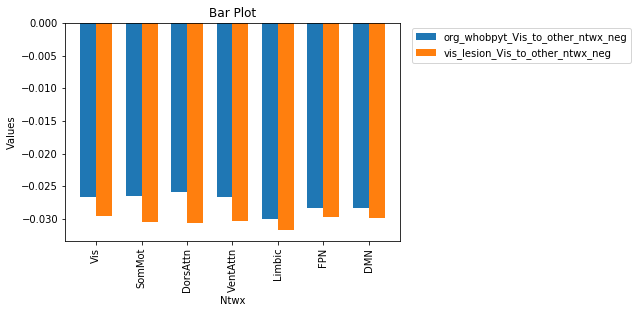

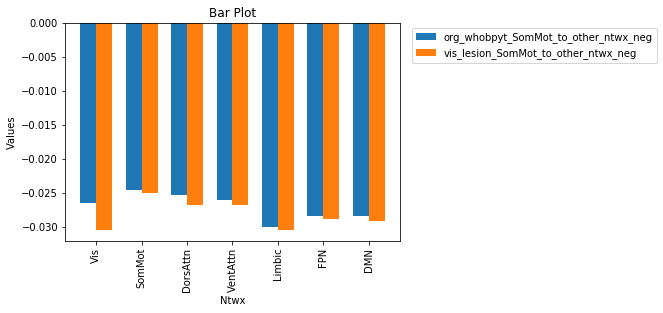

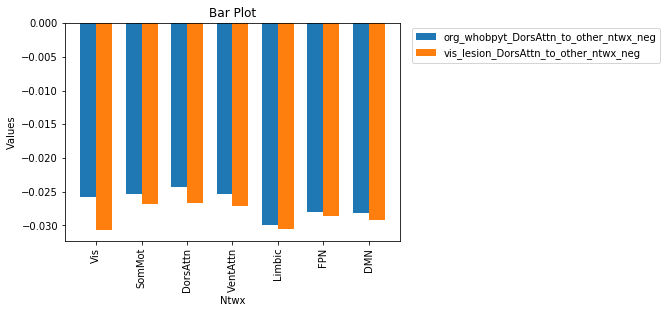

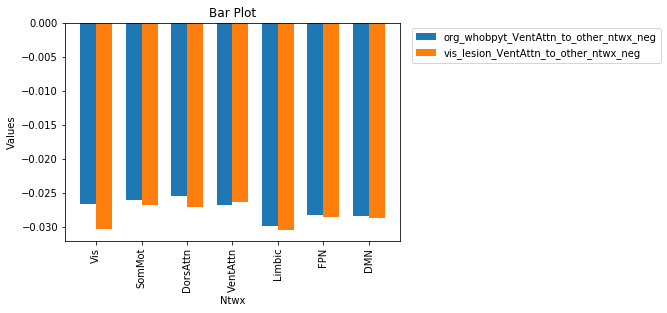

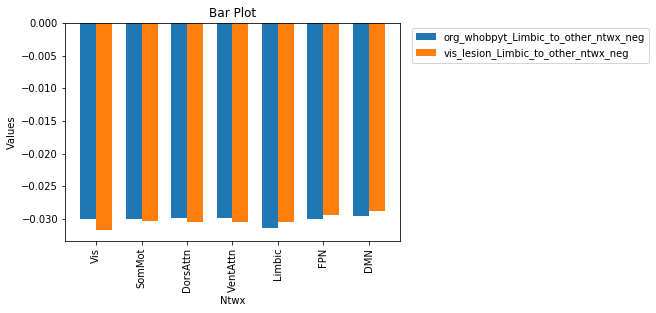

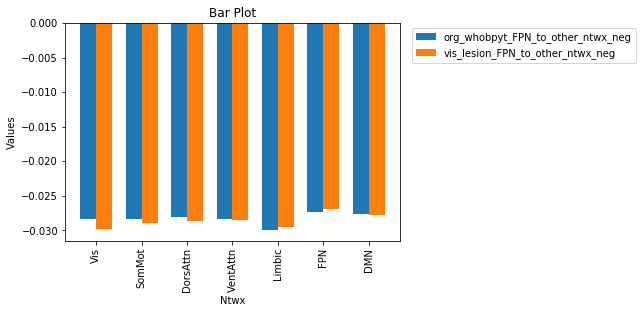

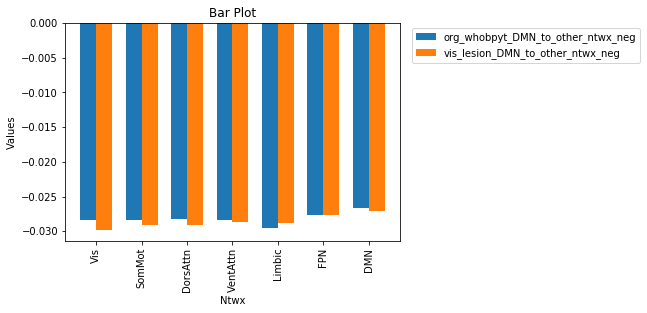

In [208]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx_neg[j], width, label='org_whobpyt_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], vis_lesion_outer_to_other_ntwx_neg[j], width, label='vis_lesion_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### SomMot

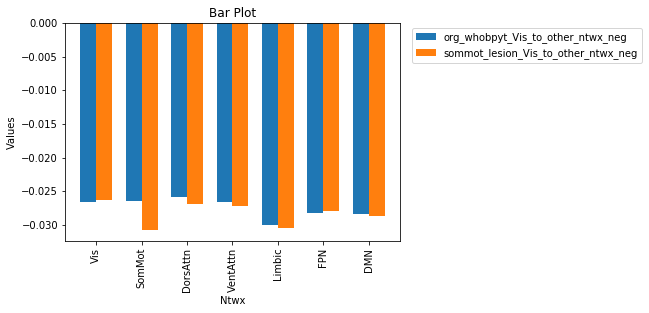

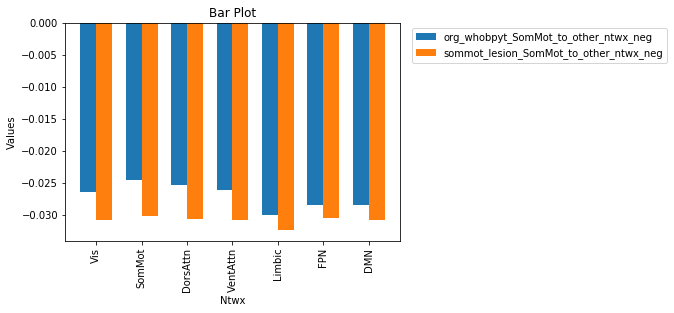

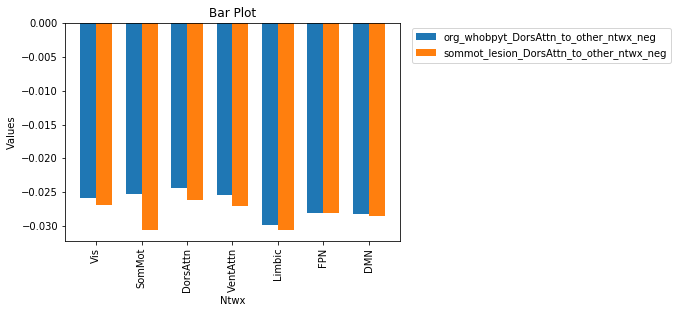

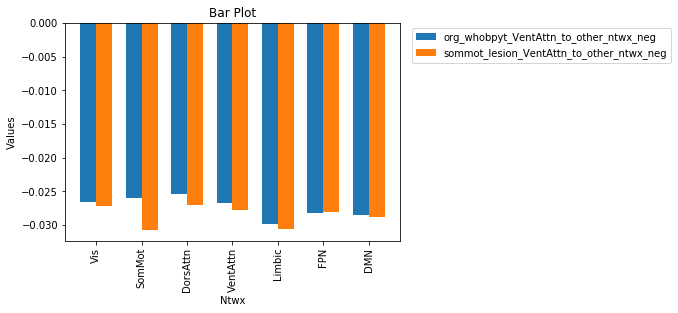

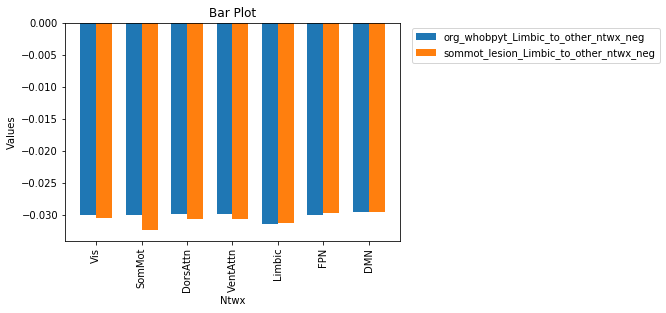

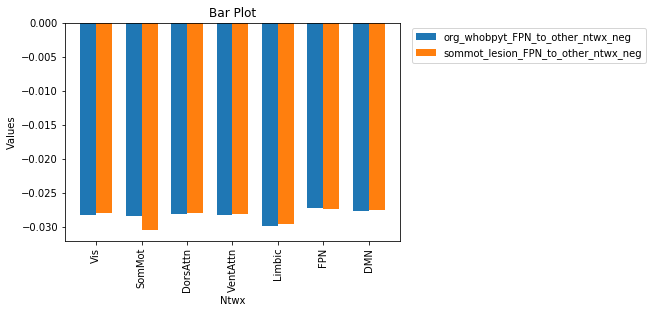

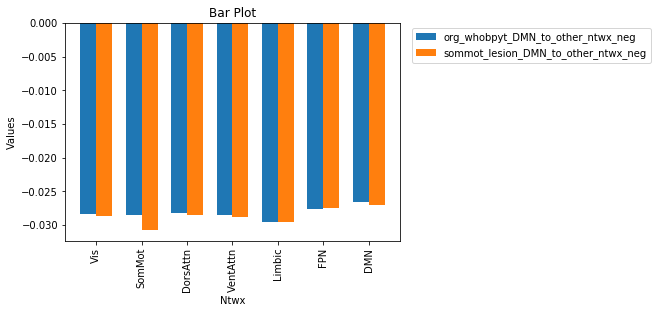

In [211]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx_neg[j], width, label='org_whobpyt_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], sommot_lesion_outer_to_other_ntwx_neg[j], width, label='sommot_lesion_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DAN

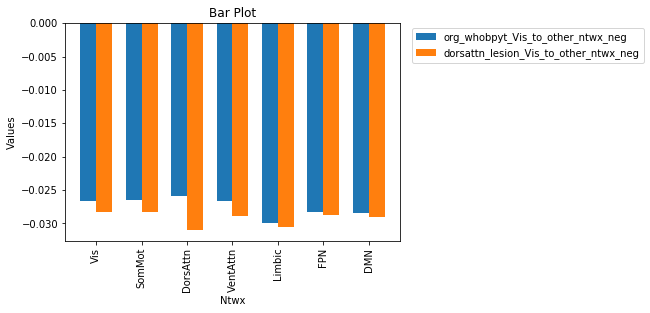

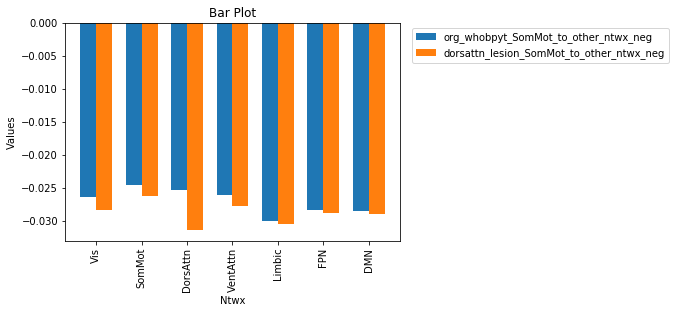

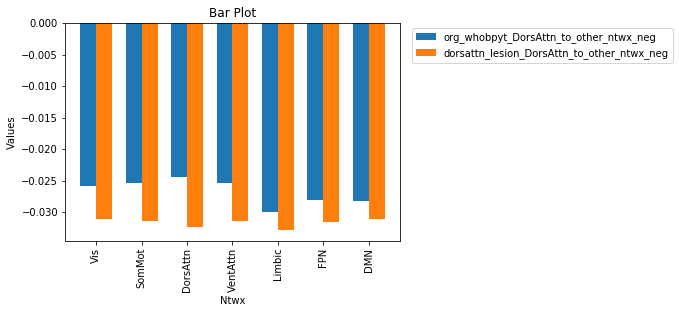

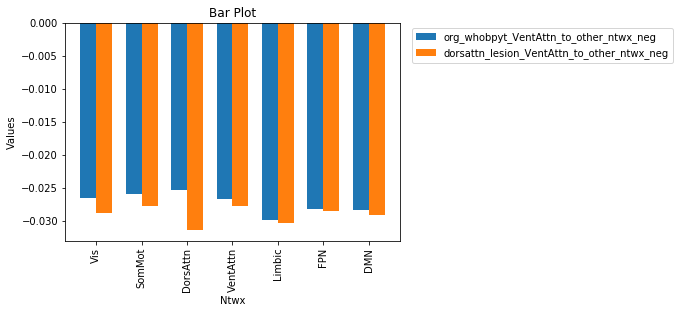

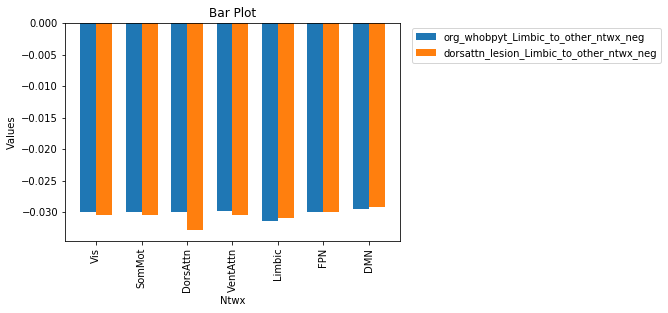

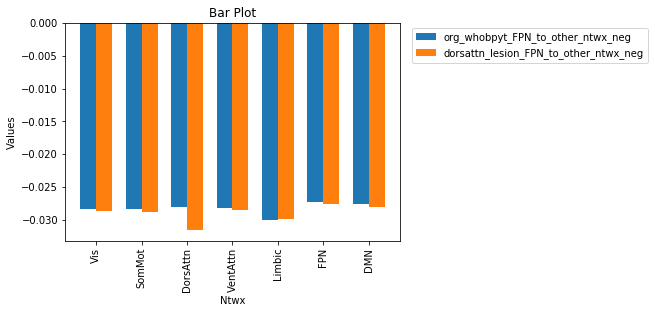

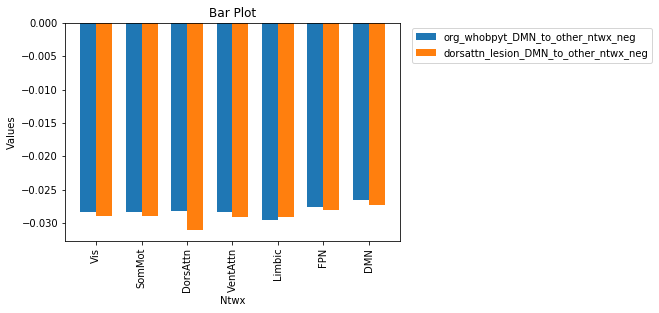

In [212]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx_neg[j], width, label='org_whobpyt_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dorsattn_lesion_outer_to_other_ntwx_neg[j], width, label='dorsattn_lesion_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### VAN

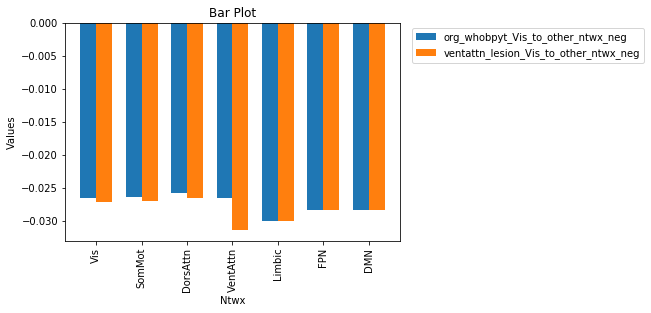

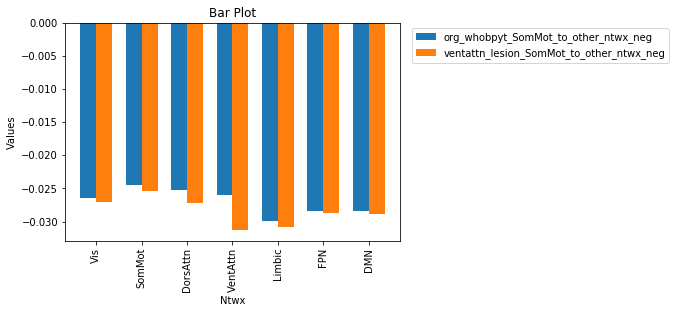

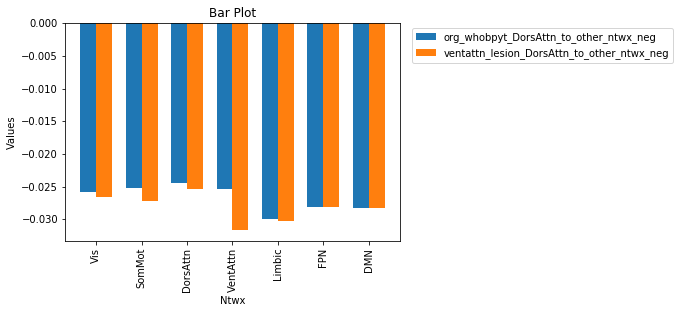

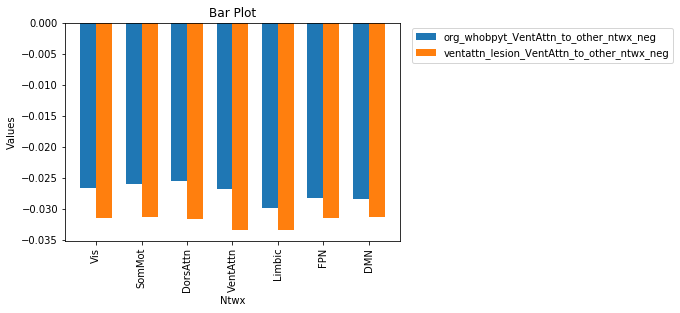

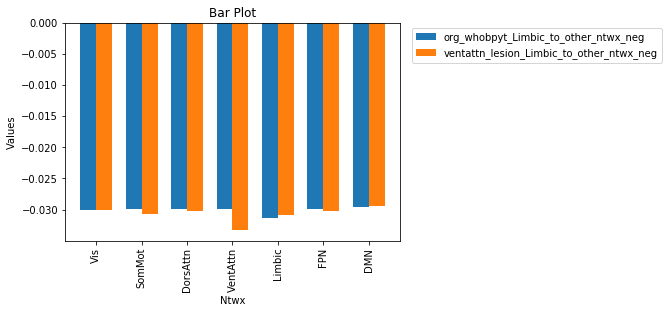

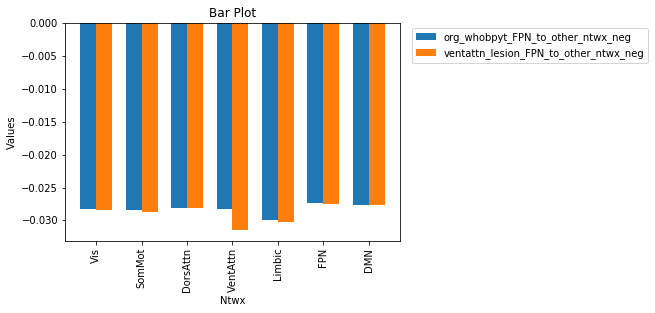

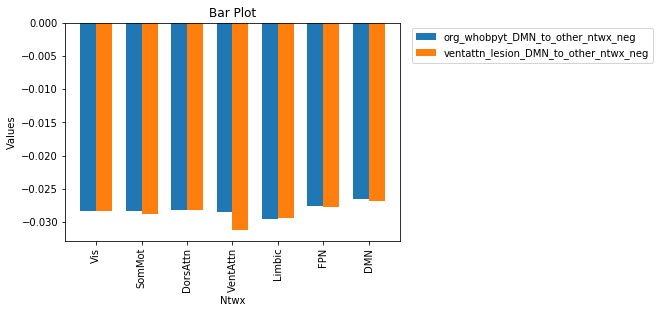

In [213]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx_neg[j], width, label='org_whobpyt_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], ventattn_lesion_outer_to_other_ntwx_neg[j], width, label='ventattn_lesion_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### limbic

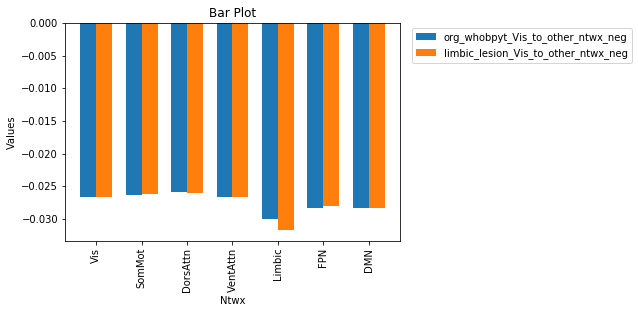

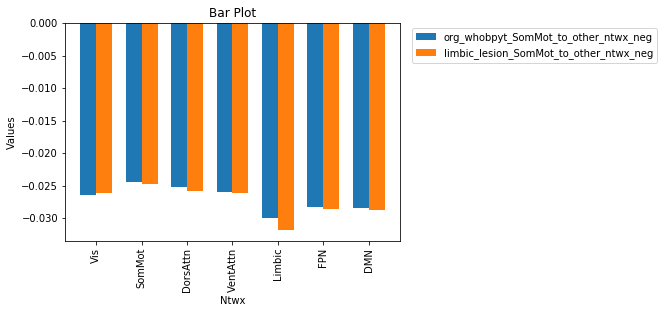

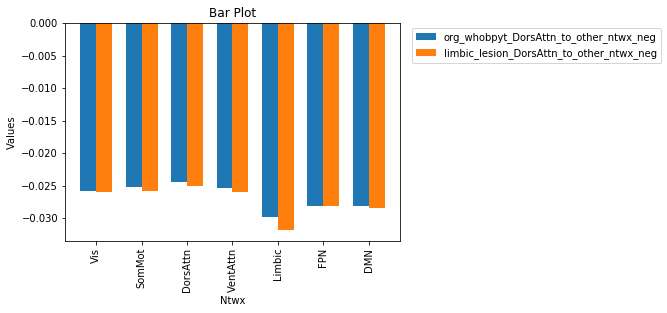

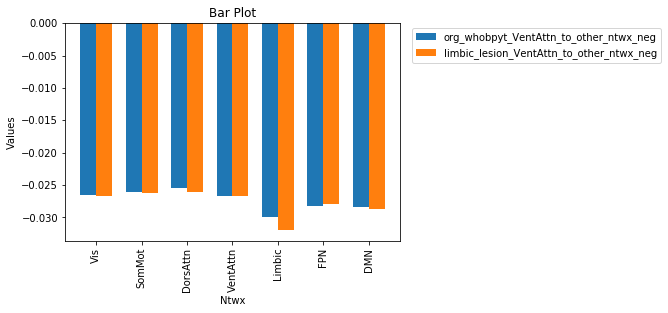

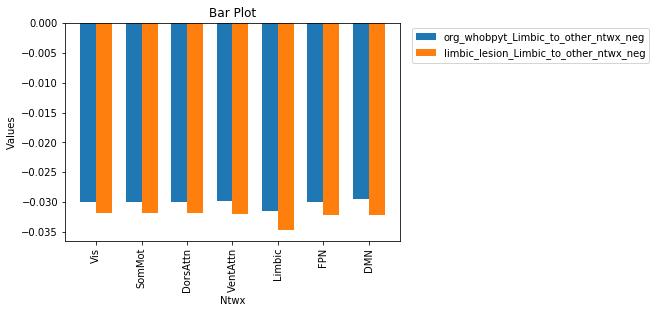

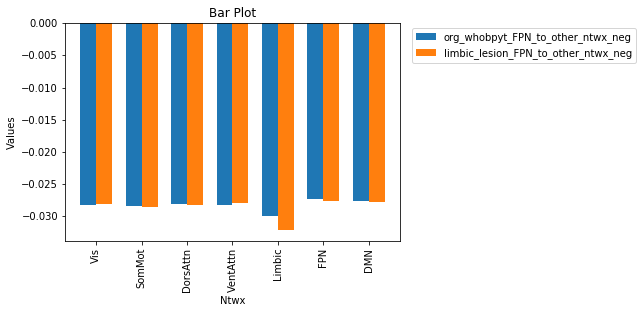

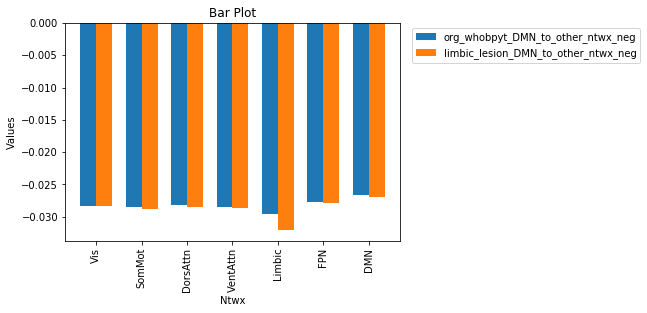

In [214]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx_neg[j], width, label='org_whobpyt_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], limbic_lesion_outer_to_other_ntwx_neg[j], width, label='limbic_lesion_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### FPN

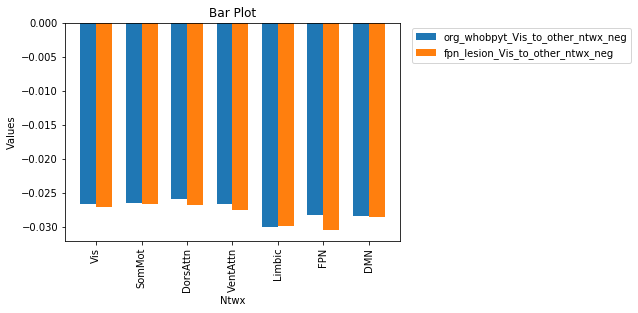

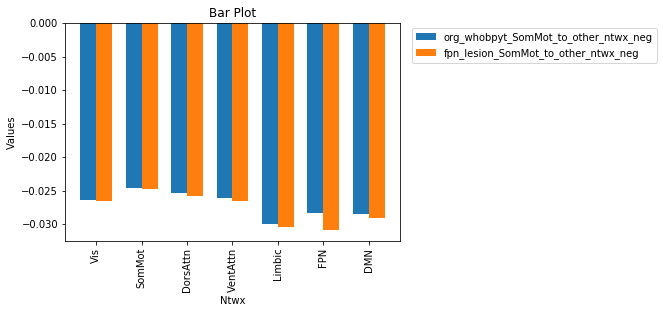

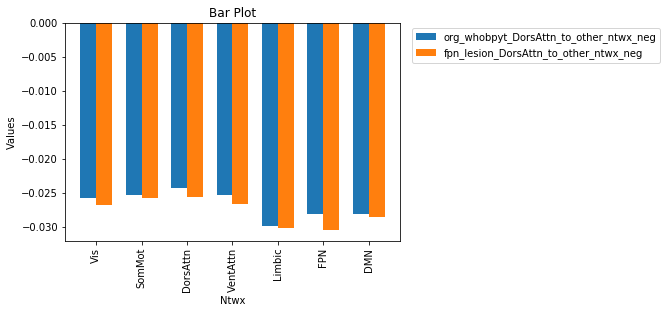

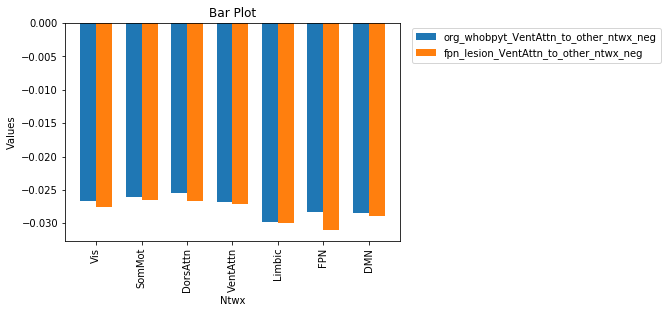

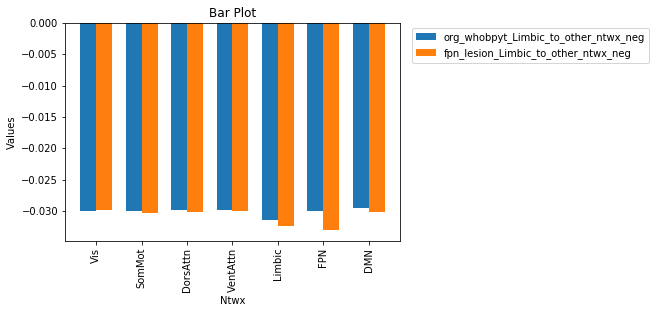

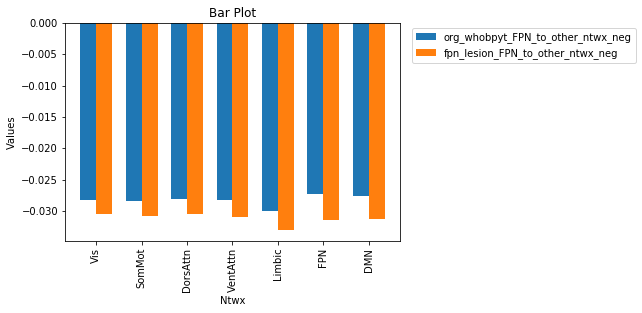

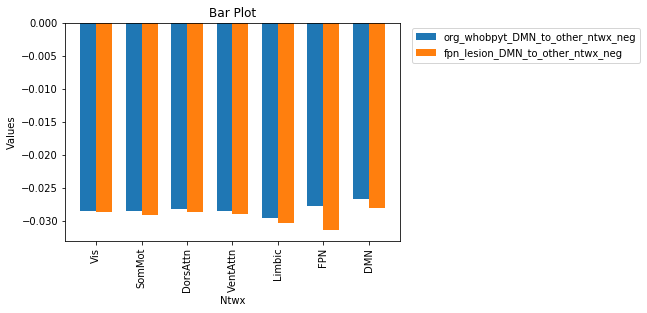

In [215]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx_neg[j], width, label='org_whobpyt_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], fpn_lesion_outer_to_other_ntwx_neg[j], width, label='fpn_lesion_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

#### DMN

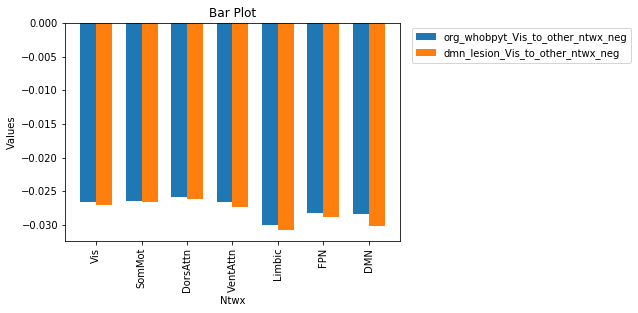

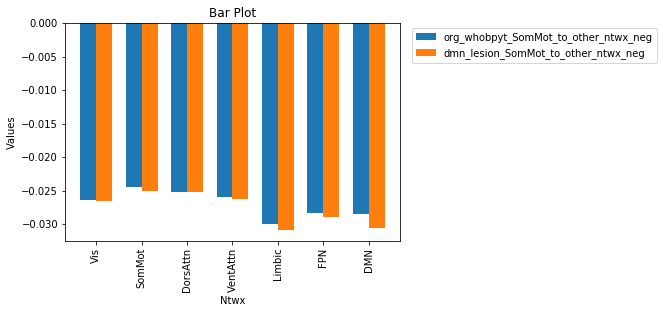

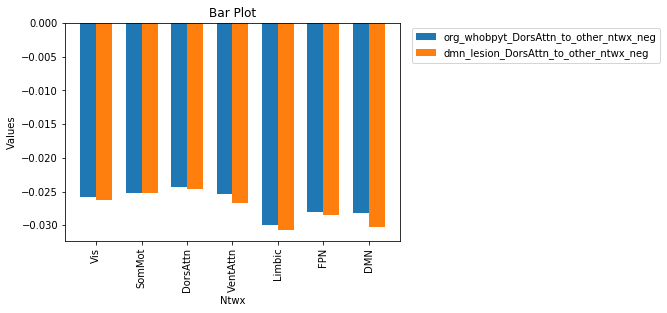

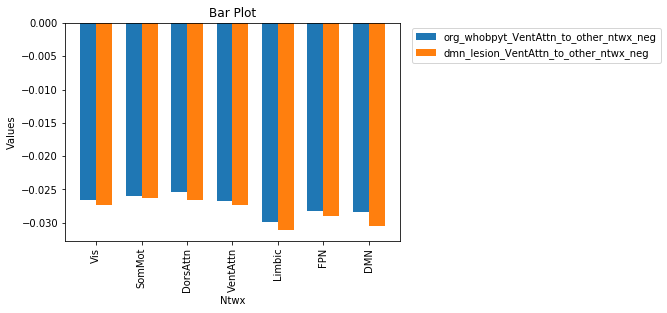

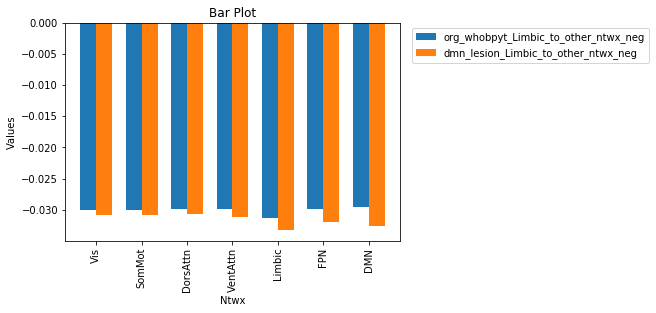

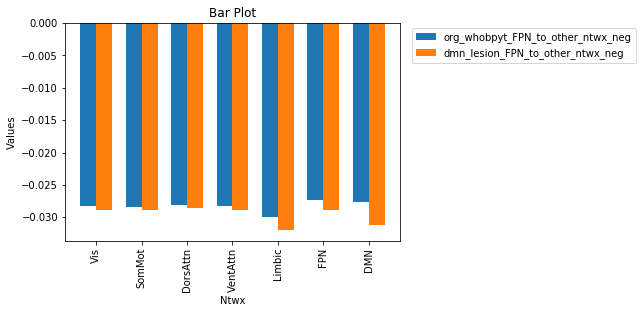

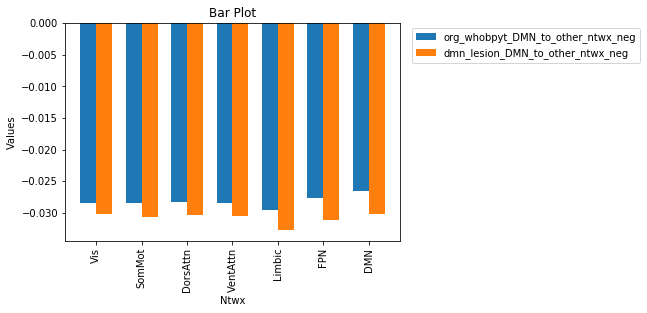

In [216]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, og_whobpyt_outer_to_other_ntwx_neg[j], width, label='org_whobpyt_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    rects2 = ax.bar([i + width for i in x], dmn_lesion_outer_to_other_ntwx_neg[j], width, label='dmn_lesion_{0}_to_other_ntwx_neg'.format(Ntwx_labels[j]))
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

In [ ]:
# Next step: re-introduce sc for each of the other networks 